# Introduction

This project is developed as the Capstone Project for the UC Berkeley Professional Certificate in Machine Learning and Artificial Intelligence Program. This project explores how ThousandEyes synthetic monitoring data—specifically Ping and HTTP can help detect early signs of outages or network degradation. The goal is to extract meaningful patterns and correlations from high-resolution time series data.

This notebook focuses first on ping metrics: packet loss and latency, measured across various virtual agents and test rounds.

## Background
In today’s digitally connected world, ensuring consistent network and application performance is vital for business operations and user satisfaction. Companies depend on performance monitoring systems to detect issues that may affect availability, latency, or user experience. However, current monitoring practices are often reactive—detecting issues only after user impact is noticeable. With the increasing complexity of distributed systems, identifying early signs of outages or systemic degradation is becoming increasingly difficult using traditional monitoring methods.
Current monitoring strategies at companies like ThousandEyes rely on collecting a wide range of network and application metrics such as packet loss, latency, and HTTP response time. However, these signals are often examined in isolation, without a structured approach to correlate them or derive predictive insights. As a result, outages are often detected reactively rather than proactively.

This project focuses on analyzing anonymized, high-resolution internal test data for Ping metrics related to Spotify, a major digital platform that experienced a recent outage. The data comes from ThousandEyes synthetic tests, which simulate user behavior to monitor network and application health in real time. A recent Spotify outage highlighted the challenge of quickly diagnosing whether an issue is network-related, application-based, or global. By studying internal ThousandEyes data corresponding to such incidents, we aim to investigate if machine learning or statistical techniques can uncover predictive indicators of impending failures.

# Load and Consolidate Raw Data

In [122]:
#Import the relevant python libraries for the analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [123]:
# Data Import and Merging 
#combine the ping files
ping_df1 = pd.read_csv('ping_spotify_1.csv')
ping_df2 = pd.read_csv('ping_spotify_2.csv')
ping_df3 = pd.read_csv('ping_spotify_3.csv')
ping_df4 = pd.read_csv('ping_spotify_4.csv')
ping_df5 = pd.read_csv('ping_spotify_5.csv')
# combine the http files
http_df1 = pd.read_csv('http_spotify_1.csv')
http_df2 = pd.read_csv('http_spotify_2.csv')
http_df3 = pd.read_csv('http_spotify_3.csv')
http_df4 = pd.read_csv('http_spotify_4.csv')
http_df5 = pd.read_csv('http_spotify_5.csv')


In [124]:
ping_df = pd.concat([ping_df1, ping_df2,ping_df3,ping_df4,ping_df5], ignore_index=True)
http_df = pd.concat([http_df1, http_df2,http_df3,http_df4,http_df5], ignore_index=True)

In [125]:
ping_df.to_csv('ping_spotify.csv', index=False, encoding='utf-8')
http_df.to_csv('http_spotify.csv', index=False, encoding='utf-8')

# Initial Data Exploration for Both Datasets

* Dataset Overview: Ping and HTTP
* Dataset Dimensions and Structure

## Data Quality and Integrity Checks
For checking types, nulls, duplicates, etc.

* Data Types and Missing Values
* Duplicate Record Check
* Null Value Handling Strategy

In [128]:
# Shape and data types
print("Ping shape:", ping_df.shape)
print("HTTP shape:", http_df.shape)

ping_df.info()
http_df.info()

# Missing values
print("Missing values in Ping data:\n", ping_df.isnull().sum())
print("Missing values in HTTP data:\n", http_df.isnull().sum())

# Duplicate rows
print("Duplicate rows in Ping:", ping_df.duplicated().sum())
print("Duplicate rows in HTTP:", http_df.duplicated().sum())

Ping shape: (863990, 6)
HTTP shape: (863991, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863990 entries, 0 to 863989
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   roundId   863990 non-null  int64  
 1   vAgentId  863990 non-null  int64  
 2   testId    863990 non-null  int64  
 3   taskId    172800 non-null  float64
 4   loss      856728 non-null  float64
 5   latency   856225 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 39.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863991 entries, 0 to 863990
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   roundId           863991 non-null  int64  
 1   vAgentId          863991 non-null  int64  
 2   testId            863991 non-null  int64  
 3   taskId            863991 non-null  int64  
 4   timing_connect    855712 non-null  float64
 5   timing_dns        

The HTTP and Ping datasets have the same number of records, which is beneficial for performing a consistent and accurate comparative analysis. For example, both Ping and HTTP datasets contain 863990, 863991 rows and 6 and 16 columns respectively as indicated by their shape.

The data types of each column help us identify quantitative features that we can use for correlation and further analysis.

In the Ping dataset, there are missing values, which could impact the accuracy of our model. To ensure data quality, we should drop rows with missing values from loss and latency. 

**In the HTTP dataset, there are missing values, however, it is interesting to see that the missing value might indicate something. For example the amount of missing values in timing_total is above the missing value in timing_firstbyte.It seems to be that NAN values indicate something going wrong within the lifecycle of HTTP request and this is indicated by the amount of NAN values increasing for further stages in the HTTP lifecycle** 

# Summary Statistics
For quick stats on all numeric fields

* Descriptive Statistics: Ping Data
*  Descriptive Statistics: HTTP Data

In [131]:
# Summary statistics
ping_df.describe()

,roundId,vAgentId,testId,taskId,loss,latency
count,8.639900e+05,863990.000000,8.639900e+05,1.728000e+05,856728.000000,856225.000000
mean,1.744545e+09,40103.697803,3.212237e+06,1.165781e+07,0.147634,33.578203
std,6.235424e+05,113356.675932,9.366763e+00,2.030177e+01,3.123664,61.024372
min,1.743466e+09,3.000000,3.212221e+06,1.165777e+07,0.000000,0.000000
25%,1.744005e+09,34.000000,3.212229e+06,1.165780e+07,0.000000,0.979167
50%,1.744546e+09,273.000000,3.212239e+06,1.165782e+07,0.000000,4.312500
75%,1.745086e+09,27665.000000,3.212244e+06,1.165782e+07,0.000000,33.152176
max,1.745625e+09,639001.000000,3.212247e+06,1.165783e+07,100.000000,2562.000000


The Ping data appears to cap at a value of 100, which may indicate a limit imposed by the test size or configuration. Most records show no packet loss, suggesting that any instances of loss may be anomalies worth investigating further.

Additionally, latency values peak around 2.5 seconds, which might indicate a timeout threshold. I plan to reach out to my team to confirm the ping timeout setting used in ThousandEyes tests—specifically, to understand when a packet is officially considered dropped.

Lets continue with ping data for now.
How many unique tests, agents do we have? How many rounds of measurements do we have?

In [134]:
print(ping_df['roundId'].nunique(), "unique roundIds")
print(ping_df['vAgentId'].nunique(), "unique vAgentIds")
print(ping_df['testId'].nunique(), "unique testIds")
print(ping_df['taskId'].nunique(), "unique taskIds")

7200 unique roundIds
38 unique vAgentIds
5 unique testIds
5 unique taskIds


### Measurement Coverage Summary (Ping Data)

The Ping dataset contains:
- **7,200 unique `roundId`s**, representing individual measurement events. This indicates a strong temporal granularity, ideal for trend and variability analysis.
- **38 unique `vAgentId`s**, reflecting diverse measurement sources. These likely span different geographies or networks, making agent-wise analysis meaningful.
- **5 unique `testId`s** and **5 `taskId`s**, suggesting a small set of test targets. This allows for controlled comparisons and easier interpretation of performance differences across agents.

These counts indicate that while the number of tests is limited, the dataset provides rich depth through repeated measurements across many agents.


### Univariate Analysis: Latency distribution and Packet loss distribution and outliers 

1. Visualizing Distribution of Packet Loss
2. Visualizing Distribution of Latency
3. Observations and Interpretation

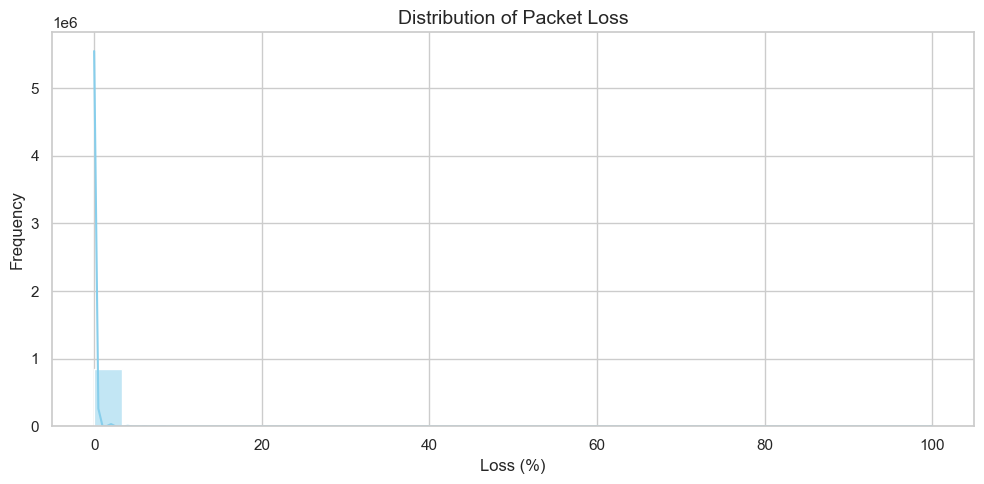

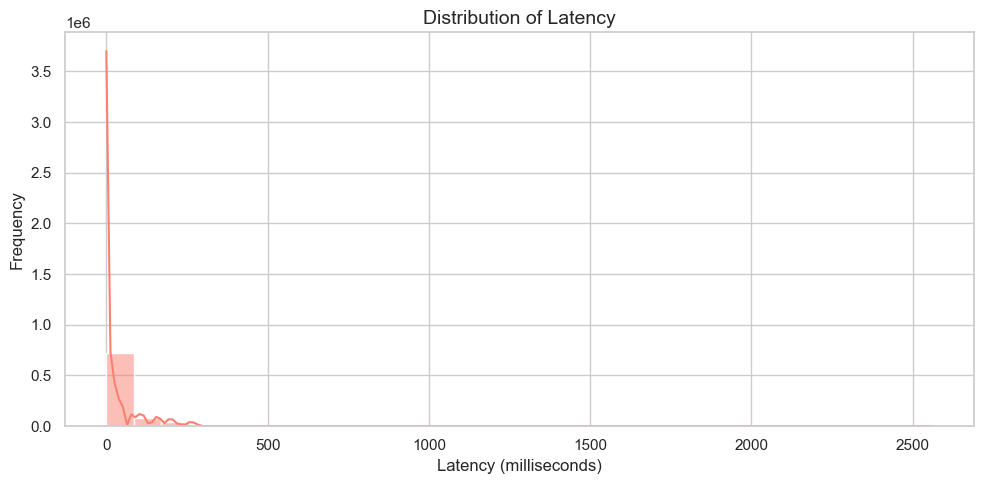

In [137]:
# Set a clean Seaborn style
sns.set(style="whitegrid")

# Set figure size and histogram for loss
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['loss'], kde=True, color="skyblue", bins=30)
plt.title("Distribution of Packet Loss", fontsize=14)
plt.xlabel("Loss (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Histogram for latency
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['latency'], kde=True, color="salmon", bins=30)
plt.title("Distribution of Latency", fontsize=14)
plt.xlabel("Latency (milliseconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations and Interpretation

- The majority of packet loss values fall between **0% and 20%**, though the distribution extends all the way to **100%**, indicating occasional severe loss events or outages.
- Latency values are mostly clustered under **500 milliseconds**, but the distribution stretches up to **2.5 seconds**, reflecting possible network delays, retransmissions, or timeouts.
- Both **packet loss** and **latency** distributions are **heavily right-skewed**, meaning that most values are low but a few extreme outliers significantly increase the range.
- This skew makes it difficult to interpret the shape of the distribution for typical behavior.

To address this, in the next part of the assignment, I can enhance by:
- Applying **log scaling** or **clip the y-axis** to better visualize the dense region of "normal" values.
- Identify and analyze **outliers** more explicitly using z-scores or IQR filtering.

We need to replot this with scaler on min and max to normalize as right it is hard to analyze.


### Scaled Univariate Analysis

* Feature Scaling using Min-Max Normalization
* Distribution Analysis of Scaled Metrics
* Outlier Detection via Boxplots
* Observations and Interpretation

Scaled Data Summary:
         loss_scaled  latency_scaled
count  856728.000000   856225.000000
mean        0.001476      327.656161
std         0.031237      595.475918
min         0.000000        0.000000
25%         0.000000        9.554711
50%         0.000000       42.081377
75%         0.000000      323.498984
max         1.000000    25000.000000


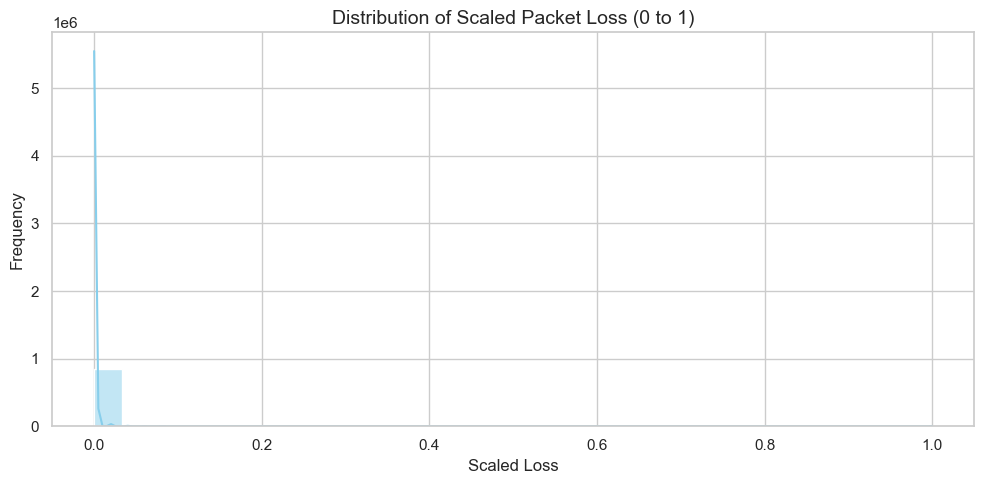

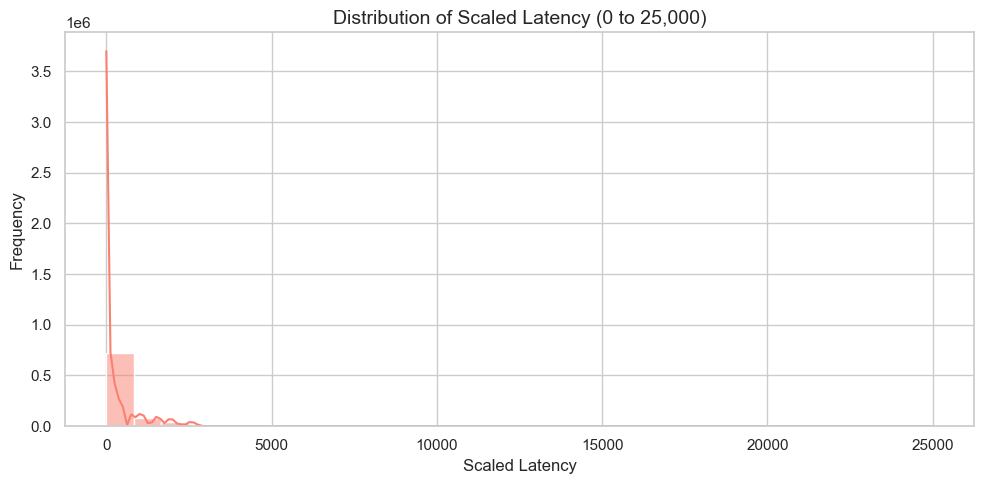

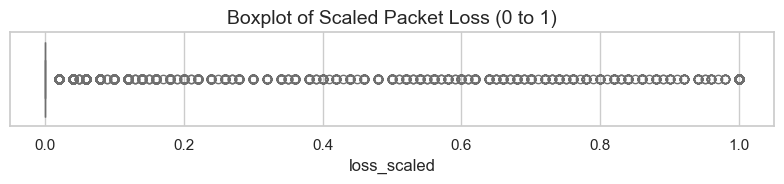

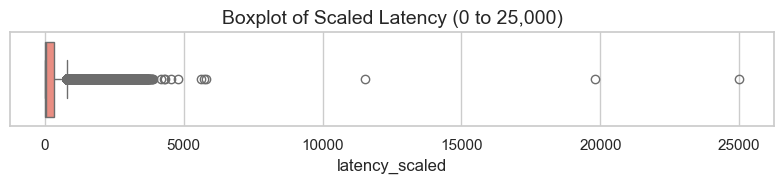

In [140]:

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale 'loss' to [0, 1]
ping_df['loss_scaled'] = scaler.fit_transform(ping_df[['loss']])

# Scale 'latency' to [0, 25000]
ping_df['latency_scaled'] = scaler.fit_transform(ping_df[['latency']]) * 25000

# Display basic statistics of scaled data
print("Scaled Data Summary:")
print(ping_df[['loss_scaled', 'latency_scaled']].describe())

# Set consistent plot style
sns.set(style="whitegrid")

# Plot histogram for scaled loss
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['loss_scaled'], kde=True, color='skyblue', bins=30)
plt.title("Distribution of Scaled Packet Loss (0 to 1)", fontsize=14)
plt.xlabel("Scaled Loss", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Plot histogram for scaled latency
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['latency_scaled'], kde=True, color='salmon', bins=30)
plt.title("Distribution of Scaled Latency (0 to 25,000)", fontsize=14)
plt.xlabel("Scaled Latency", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Boxplot for scaled loss
plt.figure(figsize=(8, 2))
sns.boxplot(x=ping_df['loss_scaled'], color='skyblue')
plt.title("Boxplot of Scaled Packet Loss (0 to 1)", fontsize=14)
plt.tight_layout()
plt.show()

# Boxplot for scaled latency
plt.figure(figsize=(8, 2))
sns.boxplot(x=ping_df['latency_scaled'], color='salmon')
plt.title("Boxplot of Scaled Latency (0 to 25,000)", fontsize=14)
plt.tight_layout()
plt.show()

# Cap the y-axis in histograms to avoid extreme values overpowering the plot:
sns.histplot(ping_df['latency_scaled'], kde=True, color='salmon', bins=30)
plt.ylim(0, 50000) 

# Add vertical lines to mark quartiles or thresholds:
plt.axvline(ping_df['latency_scaled'].mean(), color='blue', linestyle='--', label='Mean')
plt.axvline(ping_df['latency_scaled'].median(), color='green', linestyle='--', label='Median')
plt.legend()


It seems that there is a steady steam of outliers between 0-100 for packet loss and for latency it is between 0-500 milli seconds. There is a very sparse amount of outliers between 500 and 2500 milliseconds.

## Enhanced Scaled Latency Analysis with Mean and Median Reference Lines


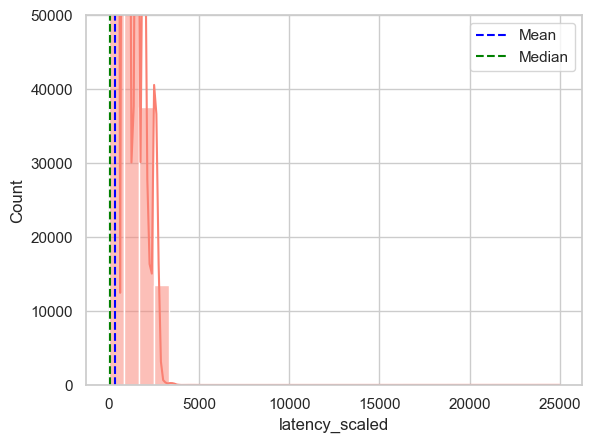

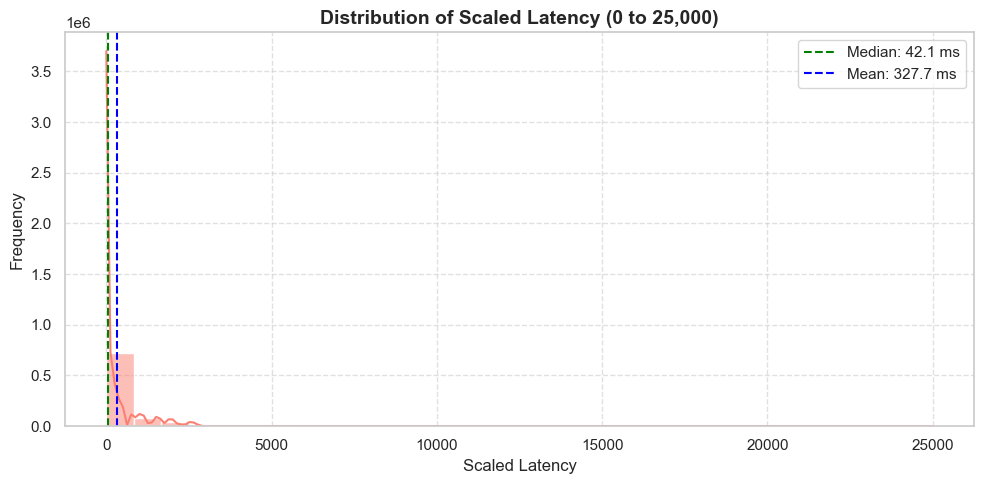

In [143]:
# Add Mean/Median Reference Lines to Histograms for visual anchor
# Plot histogram with KDE and mean/median reference lines
plt.figure(figsize=(10, 5))
sns.histplot(ping_df['latency_scaled'], kde=True, color='salmon', bins=30)

# Add mean and median lines
plt.axvline(ping_df['latency_scaled'].median(), color='green', linestyle='--', label=f"Median: {ping_df['latency_scaled'].median():.1f} ms")
plt.axvline(ping_df['latency_scaled'].mean(), color='blue', linestyle='--', label=f"Mean: {ping_df['latency_scaled'].mean():.1f} ms")

# Enhance plot aesthetics
plt.legend()
plt.title("Distribution of Scaled Latency (0 to 25,000)", fontsize=14, weight='bold')
plt.xlabel("Scaled Latency", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Observations and Interpretation

We scaled `loss` to a [0, 1] range and `latency` to a [0, 25,000] scale using MinMaxScaler for better visual interpretability and comparability across plots.

**Key Observations:**

- **Packet Loss**:
  - The histogram shows a large spike near **0**, indicating that most measurements report negligible or no packet loss.
  - However, the boxplot reveals a steady stream of **outliers in the 0–1 range**, meaning occasional high-loss events are present even though rare.
  - This aligns with the statistical summary, where even the **75th percentile is 0.0**, but the **maximum reaches 1.0**.

- **Latency**:
  - The scaled latency histogram peaks between **0–500 milliseconds**, with a sharp drop-off afterward.
  - Most requests complete quickly, as the **mean (~327 ms)** and **median (~42 ms)** indicate. However, the **long tail** stretches toward 25,000 (scaled from the max).
  - Between **500 ms and 2,500 ms**, latency is relatively sparse, suggesting that while **extreme outliers exist**, they are infrequent.

- **Skewness**: Both variables exhibit **heavy right-skewness**, reaffirming the need to use boxplots and scaling for better visual clarity.

These scaled plots help isolate normal behavior from edge cases, enabling targeted anomaly detection or filtering in later stages.


# Outlier Quantification: Scaled Latency and Packet Loss

* Threshold-Based Outlier Detection
* Outlier Summary Statistics
* Observation


In [146]:
# Quantify outliers based on scaled thresholds
latency_outliers = ping_df[ping_df['latency_scaled'] > 500]
loss_outliers = ping_df[ping_df['loss_scaled'] > 0]

# Print summary
print(f"Latency outliers (>500 ms): {len(latency_outliers):,} "
      f"({100 * len(latency_outliers)/len(ping_df):.2f}%)")

print(f"Loss outliers (>0): {len(loss_outliers):,} "
      f"({100 * len(loss_outliers)/len(ping_df):.2f}%)")


Latency outliers (>500 ms): 156,821 (18.15%)
Loss outliers (>0): 8,372 (0.97%)


### Observations and Interpretation

We quantified outliers using fixed thresholds on scaled metrics:
- **Latency outliers**: scaled latency > 500 (≈ 500 ms real-world threshold)
- **Packet loss outliers**: any scaled loss > 0 (since most values are zero)

#### 🔹 Latency:
- **18.15%** of all latency samples exceed 500 ms.
- In real-world usage, anything above **200–300 ms** can noticeably degrade the user experience — particularly for interactive applications like streaming or VoIP.
- A substantial **minority (~1 in 5)** of measurements show elevated latency, suggesting recurring performance bottlenecks.
- This could point to **network congestion, inefficient routing, remote endpoints**, or **infrastructure delays**.

#### 🔹 Packet Loss:
- **0.97%** of measurements show any packet loss.
- While this is low in aggregate, even small amounts of packet loss can **disrupt time-sensitive protocols** (like real-time video or audio).
- These outliers are worth investigating **spatially (by agent)** or **temporally (by roundId)** to isolate hotspots or problematic periods.

This outlier analysis helps prioritize areas for **root cause investigation**, **routing optimization**, or **agent performance tuning**.


In [148]:
# Break down outliers per vAgentId
latency_outliers['vAgentId'].value_counts(normalize=True).head()


vAgentId
66222    0.137628
185      0.087731
58       0.061950
4532     0.053092
7815     0.046142
Name: proportion, dtype: float64

### Top Agents with Highest Proportion of Combined Latency and Packet Loss Outliers

This table shows the **top 5 `vAgentId`s** ranked by the proportion of their measurements that exhibit **both high latency and packet loss simultaneously**—critical indicators of poor network performance.

#### Interpretation:

- **Agent 66222** stands out with nearly **14%** of its measurements flagged for both high latency and loss—more than **1 in 8 pings**. This agent likely suffers from persistent or recurring degradation and should be prioritized for investigation.
- **Agents 185 and 58** also show elevated overlap rates (9% and 6%), suggesting localized or intermittent issues.
- **Agent 7815**, previously identified during individual latency or loss analysis, reappears here—supporting the case that this agent occasionally experiences critical dual degradation.

These agents represent **"hotspots"** in the network where compounded performance issues are statistically frequent, potentially affecting end-user experience or service reliability. It would be useful to correlate these results with:
- **Geographic locations**
- **ISP or region**
- **Time-of-day trends**

to further isolate root causes or patterns.


In [150]:
latency_outliers['testId'].value_counts(normalize=True).head() 

testId
3212239    0.823978
3212244    0.094949
3212247    0.055260
3212229    0.019162
3212221    0.006651
Name: proportion, dtype: float64

### Latency Outliers by Test ID

The table below shows the **proportional distribution of latency outliers across different test targets (`testId`)**. This helps pinpoint which test destinations are most frequently associated with high latency events.

#### Interpretation:

- **Test ID 3212239** accounts for a striking **82%** of all high-latency measurements, making it the **primary contributor** to latency degradation. This strongly suggests a recurring performance issue or instability with that destination.
- The next two tests—**3212244 and 3212247**—contribute **~15% combined**, indicating more minor but still noticeable latency risks.
- The remaining test IDs account for **less than 3%** of latency outliers, implying generally stable performance.

Given the disproportionate impact of `3212239`, it should be:
- Prioritized for deeper inspection (e.g., path traces, endpoint responsiveness, or host availability).
- Correlated with agent-wise patterns to check if specific agents are struggling more with this test.
- Checked for configuration anomalies or saturation if it's a commonly hit endpoint.

This kind of test-wise breakdown helps focus troubleshooting efforts where they’re likely to have the most impact.


# Identifying Agents with Highest Loss and Latency

* Agent with Maximum Packet Loss
* Agent with Maximum Latency
* Observations and Interpretation


In [153]:
# Identify agent with maximum packet loss
max_loss_row = ping_df.loc[ping_df['loss'].idxmax()]
max_loss_agent = max_loss_row['vAgentId']
max_loss_value = max_loss_row['loss']

# Identify agent with maximum latency
max_latency_row = ping_df.loc[ping_df['latency'].idxmax()]
max_latency_agent = max_latency_row['vAgentId']
max_latency_value = max_latency_row['latency']

# Display results
print(f"Agent with maximum loss: Agent {int(max_loss_agent)} (Loss = {max_loss_value:.1f}%)")
print(f"Agent with maximum latency: Agent {int(max_latency_agent)} (Latency = {max_latency_value:.1f} ms)")

Agent with maximum loss: Agent 185 (Loss = 100.0%)
Agent with maximum latency: Agent 66 (Latency = 2562.0 ms)


### Observations and Interpretation

We identified agents that recorded the **highest single-instance values** of packet loss and latency across all measurements.

- **Agent 185** experienced a **100% packet loss**, indicating a **complete network failure or outage** during at least one round. This is a **critical event** that demands immediate investigation — possibly due to agent downtime, blocked connectivity, or extreme congestion.
  
- **Agent 66** reported a **latency spike of 2562 ms (≈2.5 seconds)**, which is significantly above acceptable thresholds. This likely represents a **transient but severe delay**, potentially due to packet retransmission, route flapping, or service degradation on the target path.

These extremes are **important edge cases** for two reasons:
1. They anchor the **worst-case performance** observed in the network.
2. They serve as **candidate events for root cause analysis** to prevent recurrence.


### Correlation between Average Loss and Latency Per Agent

* Interpretation of Correlation Results
* Next Steps and Recommendations

In [156]:
# Calculate average loss and latency per agent and check correlation:

agent_summary = ping_df.groupby('vAgentId').agg({
    'loss': 'mean',
    'latency': 'mean'
}).reset_index()

correlation = agent_summary['loss'].corr(agent_summary['latency'])
print(f"Correlation between average loss and average latency per agent: {correlation:.3f}")


Correlation between average loss and average latency per agent: 0.349


The correlation between the average packet loss and average latency per agent is 0.349, indicating a weak to moderate positive correlation. This means that agents with higher average loss tend to also exhibit somewhat higher average latency, but the relationship is not strong.
The modest correlation suggests that while there is some tendency for loss and latency to increase together, many other factors independently influence these metrics. For example, network congestion, hardware issues, or routing could affect latency without impacting loss and vice versa.
Therefore, high packet loss on an agent does not guarantee high latency, and agents with low loss might still experience high latency. This insight implies that loss and latency should be monitored and investigated separately in most cases, while also considering their combined impact on overall agent performance.

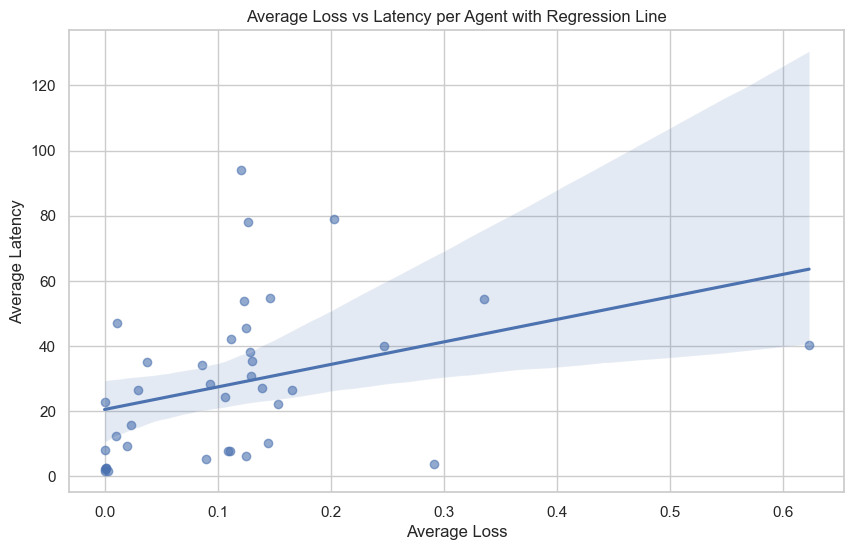

In [158]:
# Visualize the relationship

plt.figure(figsize=(10,6))
sns.regplot(data=agent_summary, x='loss', y='latency', scatter_kws={'alpha':0.6}) # alpha for point transparency
plt.title("Average Loss vs Latency per Agent with Regression Line")
plt.xlabel("Average Loss")
plt.ylabel("Average Latency")
plt.show()

 Most agents are clustered in the bottom-left corner, indicating very low average loss (close to 0) and low average latency (mostly below 50). This is a good sign, as it means most agents are performing well.
However, there are a few points that stand out:
One agent has an average loss around 0.3 (30%) with very low average latency (around 5).
Another agent has an average loss around 0.6 (60%) with very low average latency (around 5).
Several agents show higher average latencies (e.g., one around 90, others around 50-60) but still maintain very low average loss.
This visual distribution reinforces that high average loss doesn't necessarily mean high average latency, and vice-versa, for all agents, even with a general positive trend. The agents with high average loss but low average latency might be experiencing packet drops without significant delays for the packets that do get through.

### Understanding Agent Performance: A Comparative Analysis of Network Latency and Packet Loss

/var/folders/t1/pzg0tvcd5mq3dn6h905_ds740000gn/T/ipykernel_34484/473862638.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, y='vAgentId', x=metric, order=top_agents, palette=palette)
/var/folders/t1/pzg0tvcd5mq3dn6h905_ds740000gn/T/ipykernel_34484/473862638.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df_filtered.groupby('vAgentId')[metric].median()


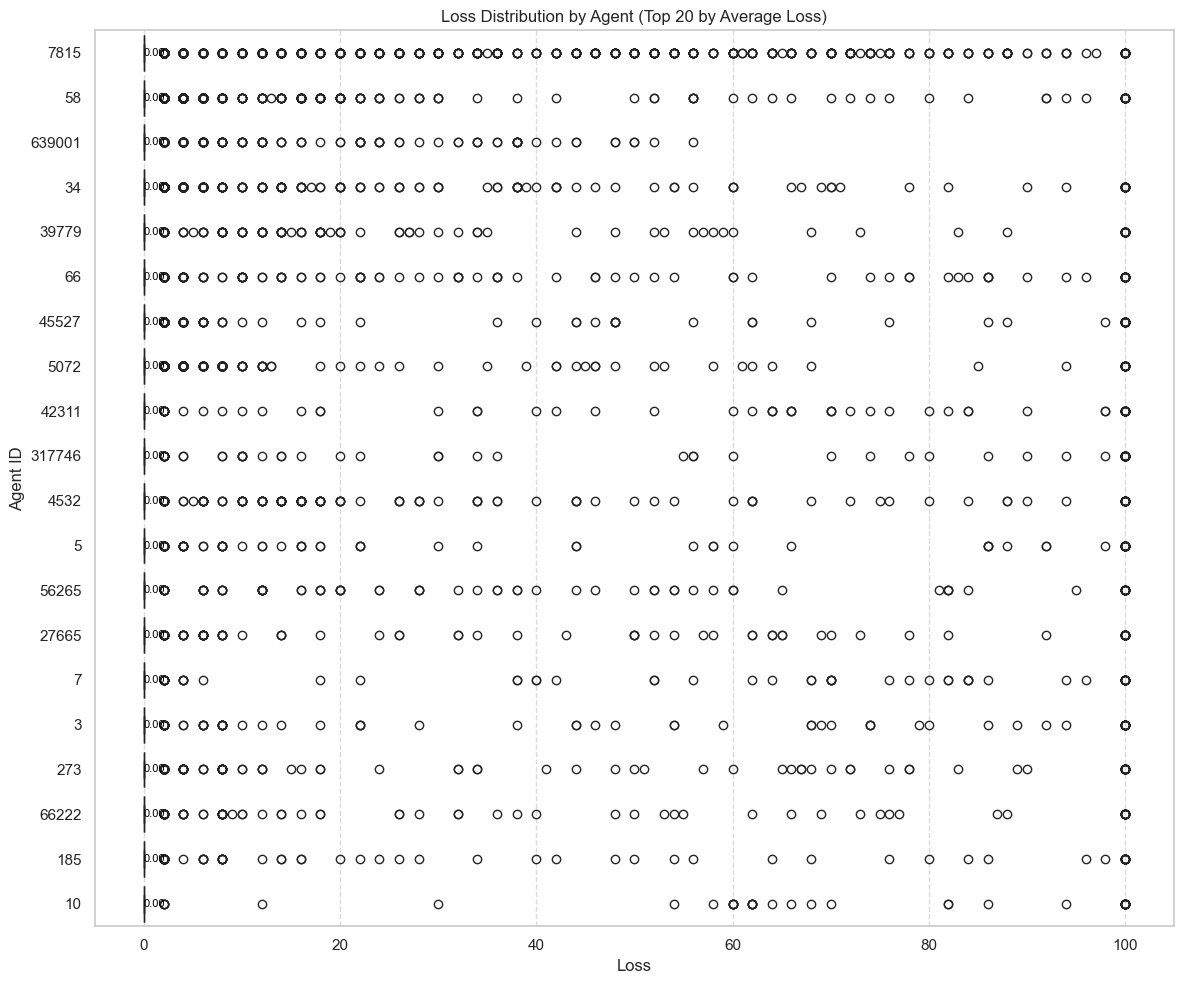

/var/folders/t1/pzg0tvcd5mq3dn6h905_ds740000gn/T/ipykernel_34484/473862638.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, y='vAgentId', x=metric, order=top_agents, palette=palette)
/var/folders/t1/pzg0tvcd5mq3dn6h905_ds740000gn/T/ipykernel_34484/473862638.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df_filtered.groupby('vAgentId')[metric].median()


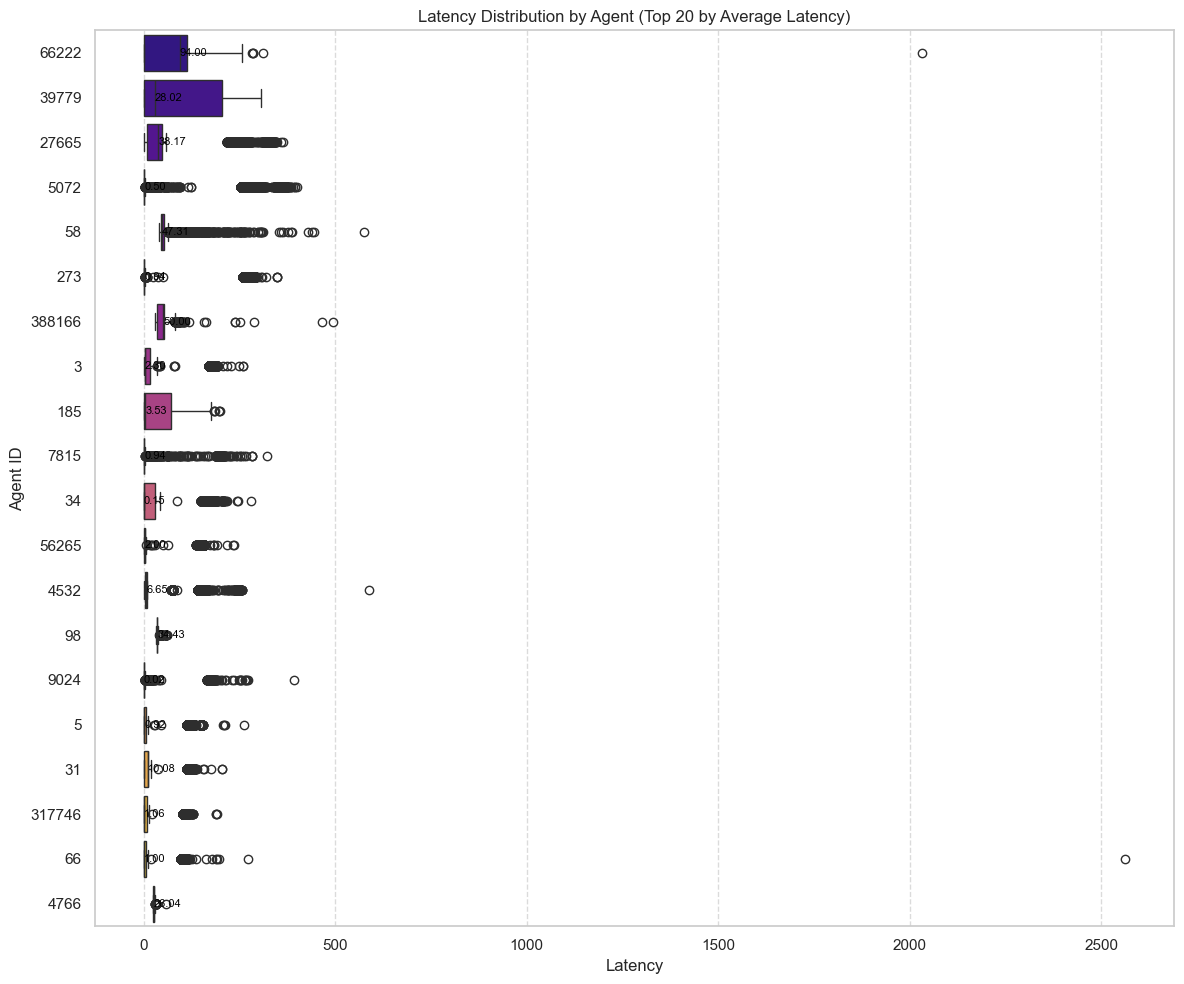

In [161]:
def plot_metric_distribution(df, metric, num_agents=20, palette='viridis'):
    # Calculate average of the selected metric
    agent_avg = df.groupby('vAgentId')[metric].mean().sort_values(ascending=False)
    top_agents = agent_avg.index[:num_agents]

    # Filter and prepare dataframe
    df_filtered = df[df['vAgentId'].isin(top_agents)].copy()
    df_filtered['vAgentId'] = pd.Categorical(df_filtered['vAgentId'], categories=top_agents, ordered=True)

    # Plot
    plt.figure(figsize=(12, 0.5 * num_agents))
    sns.boxplot(data=df_filtered, y='vAgentId', x=metric, order=top_agents, palette=palette)
    plt.title(f"{metric.capitalize()} Distribution by Agent (Top {num_agents} by Average {metric.capitalize()})")
    plt.xlabel(metric.capitalize())
    plt.ylabel("Agent ID")
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Add median values
    medians = df_filtered.groupby('vAgentId')[metric].median()
    for idx, agent in enumerate(top_agents):
        plt.text(medians[agent], idx, f"{medians[agent]:.2f}", va='center', ha='left', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

# Usage
plot_metric_distribution(ping_df, 'loss', num_agents=20, palette='viridis')
plot_metric_distribution(ping_df, 'latency', num_agents=20, palette='plasma')


Agent 66222 has the highest average latency, with a median around 100ms and a wide spread, including significant outliers over 2000ms. Many agents show low median latency but exhibit high latency outliers (e.g., Agent 4766 with an outlier around 2500ms), indicating intermittent performance issues.


Loss Analysis: This scatter plot shows the distribution of packet loss percentages for the top 20 agents by average loss. Each dot represents a recorded packet loss percentage for an agent. The density and spread of these dots indicate the frequency and magnitude of loss events. Agents are ordered by their average loss. Agent 7815 appears to experience frequent and varied packet loss, with values distributed across the entire 0-100% range. Other agents like 639001, 58, 34, and 5072 also show significant loss events, while some agents (e.g., 185) show loss occurring at specific, discrete percentages.
Overall this visual helps to quickly see which agents are contributing most to high latency or packet loss. This helps us further distinguish between agents with consistently high metrics versus those that experience intermittent spikes or outliers. Further, with this analysis we can focus efforts on agents that show the most critical performance degradation.


### Calculate Average Loss and Latency per Test

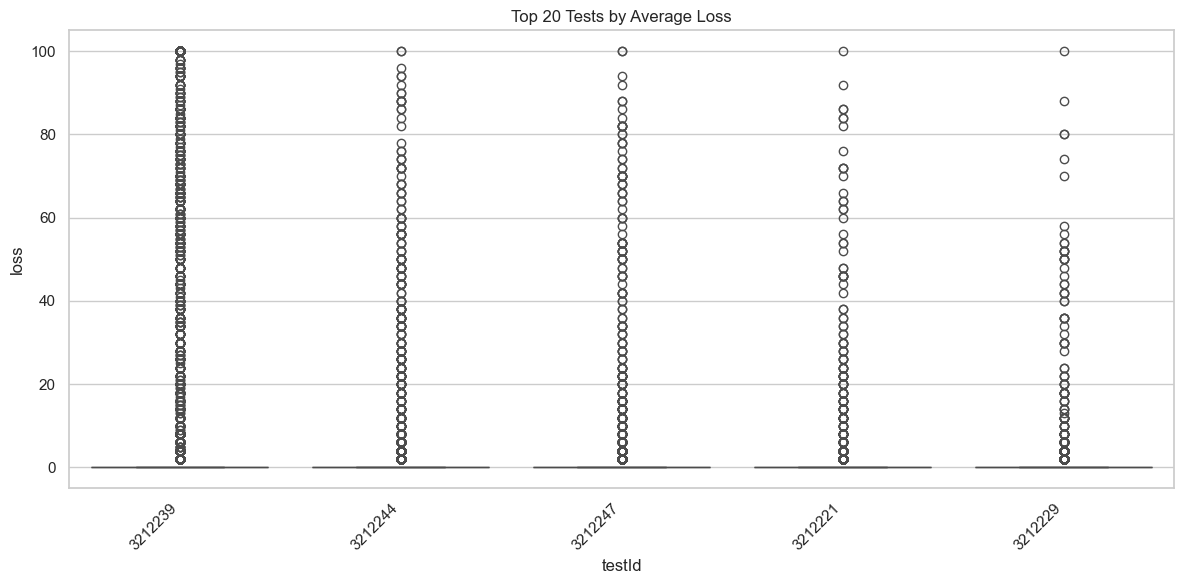

In [164]:
# Group by testId and compute average loss and latency
test_stats = ping_df.groupby('testId')[['loss', 'latency']].mean().reset_index()

# Sort values for visualization
top_loss_tests = test_stats.sort_values('loss', ascending=False).head(20)
top_latency_tests = test_stats.sort_values('latency', ascending=False).head(20)

#Filter Original Data for Top Tests
# Filter original DataFrame to include only the top 20 testIds (for each metric)
loss_subset = ping_df[ping_df['testId'].isin(top_loss_tests['testId'])]
latency_subset = ping_df[ping_df['testId'].isin(top_latency_tests['testId'])]

# Order testIds categorically by average metric for clear plotting
loss_order = top_loss_tests['testId']
latency_order = top_latency_tests['testId']

# Visualize Loss Distribution by Test
plt.figure(figsize=(12, 6))
sns.boxplot(data=loss_subset, x='testId', y='loss', order=loss_order)
plt.title("Top 20 Tests by Average Loss")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



We calculate the average `loss` and `latency` for each `testId` to identify the top 20 tests with the worst performance on each metric. 
We convert the test IDs into ordered categorical variables to ensure the plots show bars sorted by average metric values.


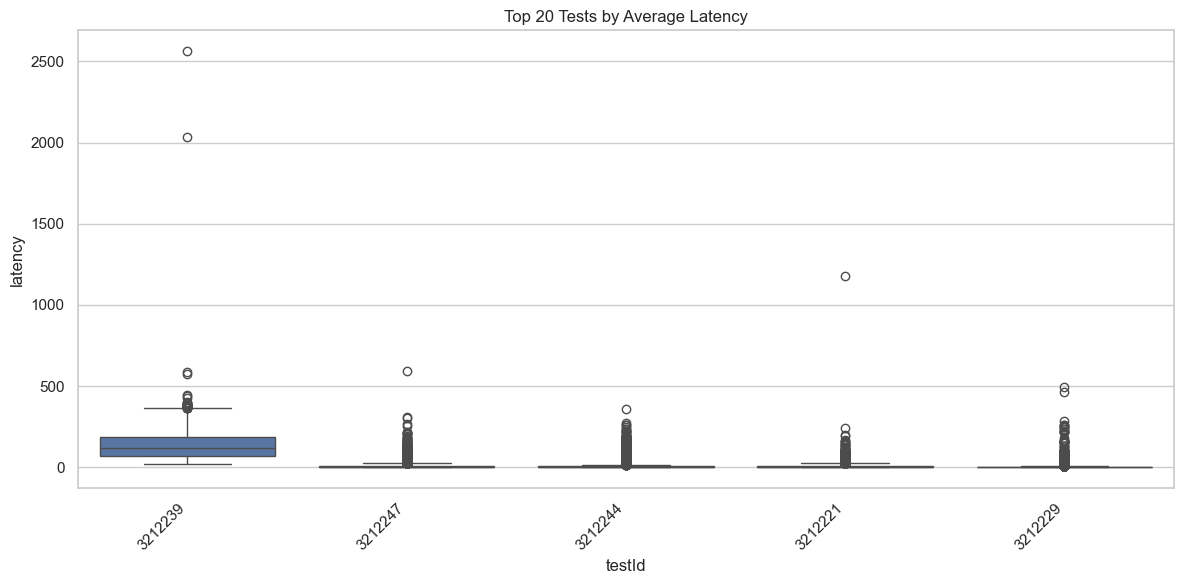

In [166]:
# Visualize Latency Distribution by Test
plt.figure(figsize=(12, 6))
sns.boxplot(data=latency_subset, x='testId', y='latency', order=latency_order)
plt.title("Top 20 Tests by Average Latency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Filter Data to Include Only Top 20 Tests
To visualize distributions effectively, we subset the original data to only include the top 20 test IDs (based on average loss and latency respectively).


In [168]:
# Full sorted table for reference
print(test_stats.sort_values(by='loss', ascending=False))  # or by='latency'

    testId      loss     latency
2  3212239  0.537471  128.045843
3  3212244  0.072069   10.937131
4  3212247  0.055648   12.023083
0  3212221  0.037710   10.366178
1  3212229  0.028951    5.932597


### Noteworthy Observation

From the analysis, `testId = 3212239` stands out as one of the worst-performing tests:
- It ranks among the top in average **loss** and **latency**.
- The box plots show high variability and/or frequent outliers.
- This test should be prioritized for deeper investigation.


In [170]:
# Handle Missing Values
ping_df = ping_df.dropna(subset=['loss', 'latency'])  # Drop rows with NaN values

Handle Missing Values in Loss and Latency: 
Before performing statistical or visual analyses, we remove any rows with missing values (`NaN`) in the `loss` or `latency` columns. This ensures that subsequent calculations like averages and correlations are accurate and not skewed by incomplete data.


Correlation matrix:
              loss   latency
loss     1.000000  0.042499
latency  0.042499  1.000000
Correlation matrix:
              loss   latency
loss     1.000000 -0.026196
latency -0.026196  1.000000


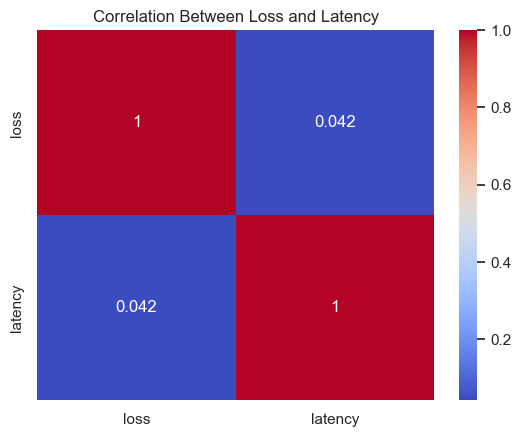

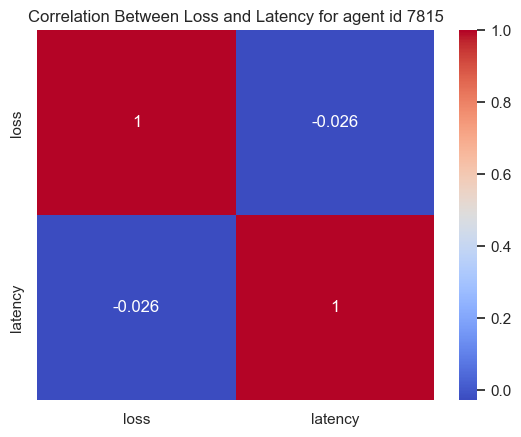

In [172]:
# lets analyze the correlation between loss and latency and for one agent ID 7815.
# Correlation matrix
correlation_matrix = ping_df[['loss', 'latency']].corr()
print("Correlation matrix:\n", correlation_matrix)

#Coorelation matrix for agent ID 7815
correlation_matrix_agent = ping_df[ping_df['vAgentId'] == 7815][['loss', 'latency']].corr()
print("Correlation matrix:\n", correlation_matrix_agent)

# Heatmap for correlation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Loss and Latency")
plt.show()

# Heatmap for correlation
sns.heatmap(correlation_matrix_agent, annot=True, cmap='coolwarm')
plt.title("Correlation Between Loss and Latency for agent id 7815")
plt.show()

### Summary of Findings

Based on the analysis above, we observed that certain `testId`s and `vAgentId`s consistently exhibit high outlier values in both **latency** and **packet loss** when accessing Spotify services. These anomalies likely correspond to periods of **network degradation** or **localized outages**, evidenced by significant spikes in the associated metrics.

While it was initially hypothesized that high latency and high loss might be correlated for specific agents, our analysis of `agentId = 7815` did **not** show a strong correlation. This suggests that **correlation analysis may not be a reliable diagnostic tool on a per-agent level**, and network issues may manifest differently across various metrics.

### Implications for Further Analysis

Unlike the Ping dataset, the HTTP dataset contains **richer feature sets** (e.g., DNS time, SSL handshake time, HTTP response codes, etc.) which can provide **finer granularity** into where exactly performance issues occur — especially **beyond just connection setup**.

This allows us to:
- Isolate issues related to DNS resolution, SSL negotiation, and server response.
- Identify specific application-layer failures even when network connectivity is intact.
- Investigate slowdowns or outages that are **not captured by ping-based metrics alone**.

**Note - After discussing internally and learing coordinator, I included HTTP metrics in the analysis. Additionally, test to test and agent to agent comparison from Thousandeyes perspective does not make sense since it could be pointing to different geo locations. Hence, in HTTP metrics I would not be including for depth analysis. Only keeping it for project analysis to show understanding of the data.**


### Data Preview and Understanding for HTTP Metrics

In [175]:
#Summary statistics
http_df.describe()

,roundId,vAgentId,testId,taskId,timing_connect,timing_dns,timing_firstbyte,timing_receive,timing_redirect,timing_send,timing_ssl,timing_total,timing_wait,tput,curlret,responsecode
count,8.639910e+05,863991.000000,8.639910e+05,8.639910e+05,855712.000000,856714.000000,853319.000000,853287.000000,315315.000000,855704.000000,855704.000000,853287.000000,853319.000000,3.654720e+05,863991.000000,853318.000000
mean,1.744545e+09,40103.657257,3.212237e+06,1.165781e+07,13.063317,53.370718,275.889746,11.752516,427.127684,0.246264,32.572372,287.594283,176.863238,5.234963e+06,0.109449,200.266158
std,6.235430e+05,113356.616597,9.366761e+00,2.030072e+01,48.191275,140.150423,304.987363,43.303199,423.290177,0.154830,59.726896,314.246274,236.860056,5.367423e+06,1.743480,8.957263
min,1.743466e+09,3.000000,3.212221e+06,1.165777e+07,0.159000,0.015000,12.864000,0.017000,18.972000,0.089000,1.523000,13.330000,0.230000,0.000000e+00,0.000000,200.000000
25%,1.744005e+09,34.000000,3.212229e+06,1.165780e+07,1.111000,0.620000,76.423000,0.206000,127.221500,0.181000,6.108000,78.852000,44.786000,8.890870e+05,0.000000,200.000000
50%,1.744546e+09,273.000000,3.212239e+06,1.165782e+07,2.281000,9.485000,182.214000,0.693000,261.406998,0.223000,12.111000,187.695000,104.619000,3.134387e+06,0.000000,200.000000
75%,1.745086e+09,27665.000000,3.212244e+06,1.165782e+07,9.601000,46.403000,374.042995,3.859000,637.237000,0.285000,36.030000,390.373501,208.421500,7.798182e+06,0.000000,200.000000
max,1.745625e+09,639001.000000,3.212247e+06,1.165783e+07,3397.464000,4899.780762,4979.820001,4216.263000,4993.339000,38.334000,4921.736000,4977.757100,4920.108000,3.605100e+07,35.000000,504.000000


We start by reviewing the structure and basic statistics of the HTTP dataset (`http_df`). This includes checking column names, and summary statistics. This step helps us identify which fields are numeric, which contain missing values, and which are suitable for analysis. Thousandeyes research team gave me an understanding of the timing_firstbyte and timing_total columns which are as follows: 
```
timing_firstbyte = timing_dns + timing_connect + timing_ssl (optional) + timing_send + timing_wait
timing_total     = timing_dns + timing_connect + timing_ssl (optional) + timing_send + timing_wait + timing_receive
```

In [177]:
#Lets analyze the HTTP data for now
# How many unique tests, agents do we have? How many rounds of measurements do we have?
print(http_df['roundId'].nunique(), "unique roundIds")
print(http_df['vAgentId'].nunique(), "unique vAgentIds")
print(http_df['testId'].nunique(), "unique testIds")
print(http_df['taskId'].nunique(), "unique taskIds")

7200 unique roundIds
38 unique vAgentIds
5 unique testIds
5 unique taskIds


### Dataset Scope and Measurement Coverage

We begin the analysis by understanding the scope and granularity of the HTTP dataset:

- **7,200 unique `roundId`s** indicate the number of individual measurement rounds (i.e., HTTP checks or probes). This provides a solid temporal depth for trend analysis and variability assessment.
- **38 unique `vAgentId`s** represent the different agents (measurement points), which likely span various geographic or network locations.
- **5 unique `testId`s** and **5 `taskId`s** suggest that the dataset covers a small set of distinct test configurations — each potentially targeting different endpoints, protocols, or behaviors.


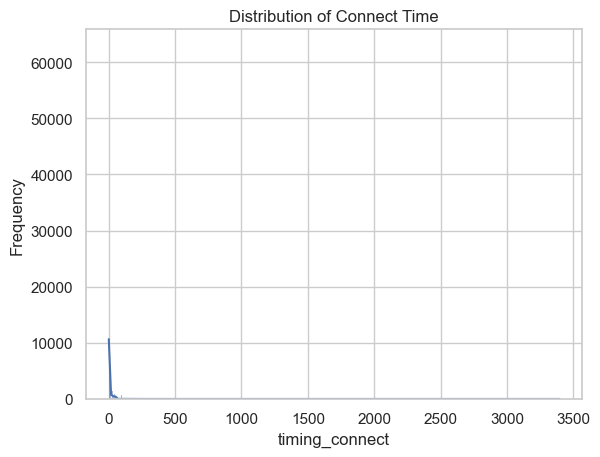

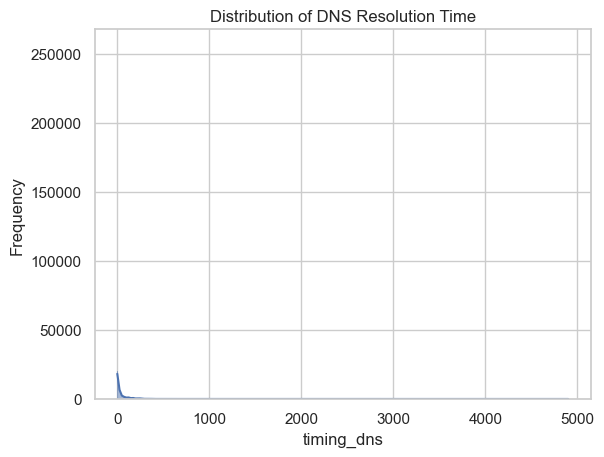

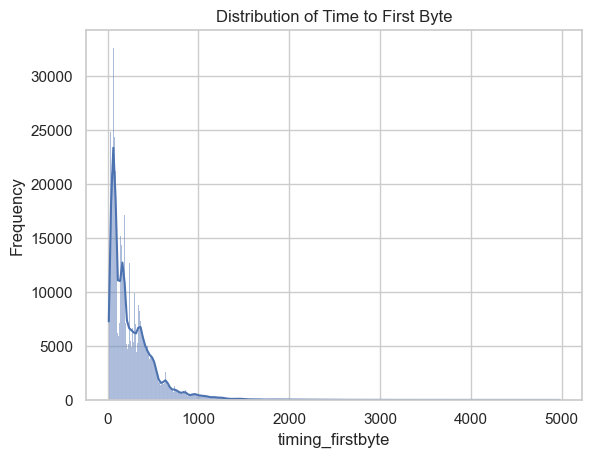

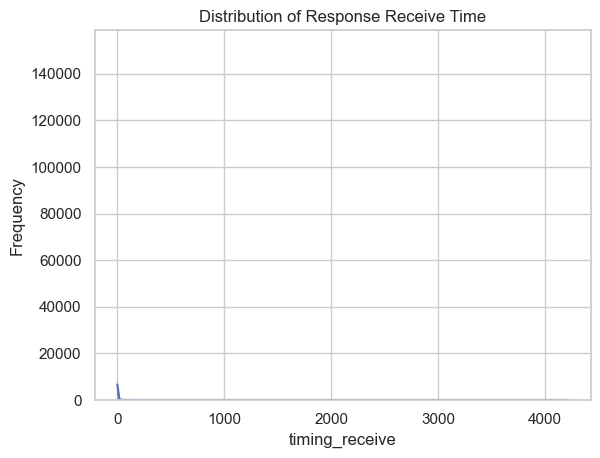

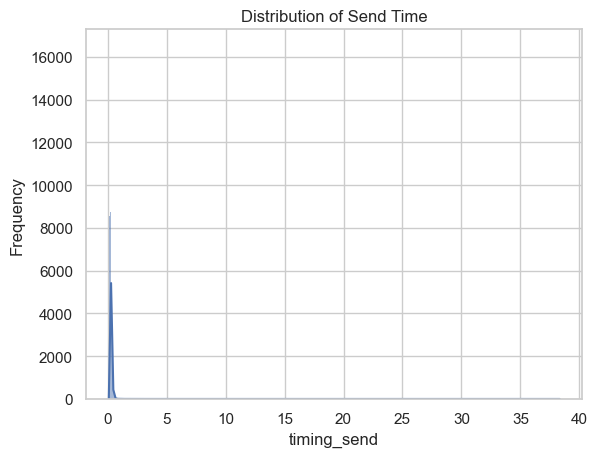

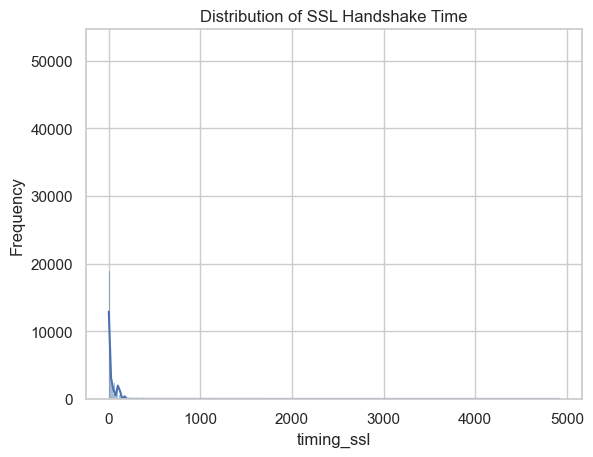

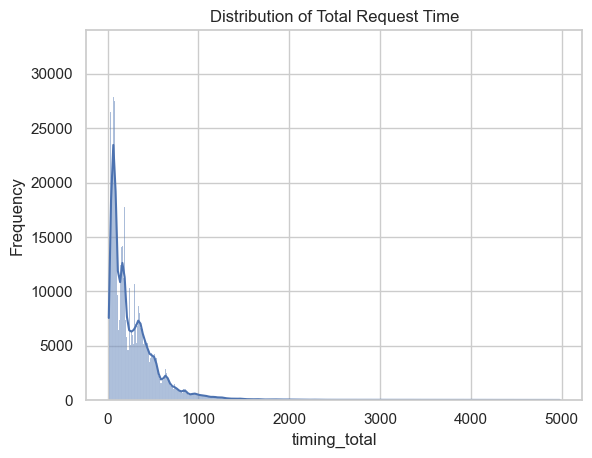

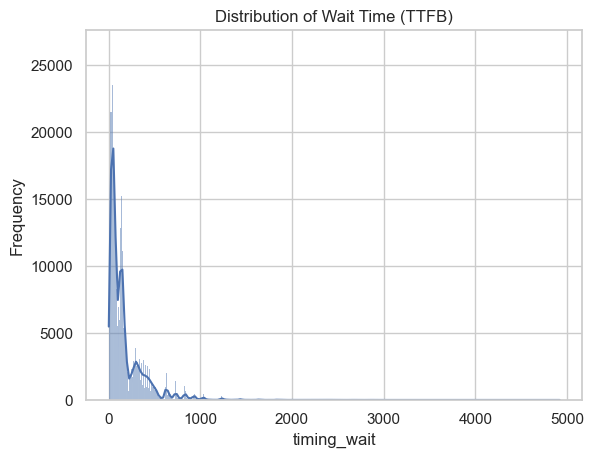

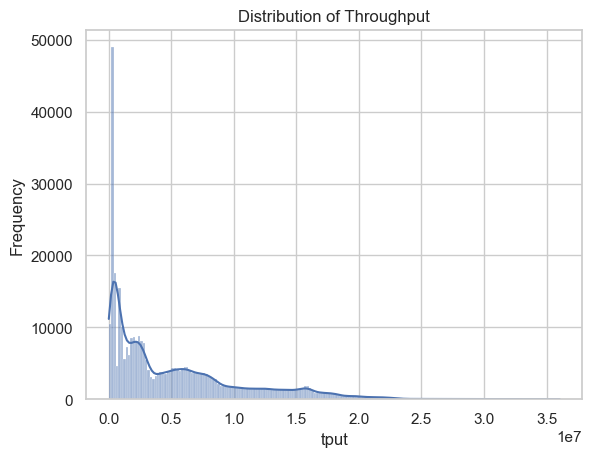

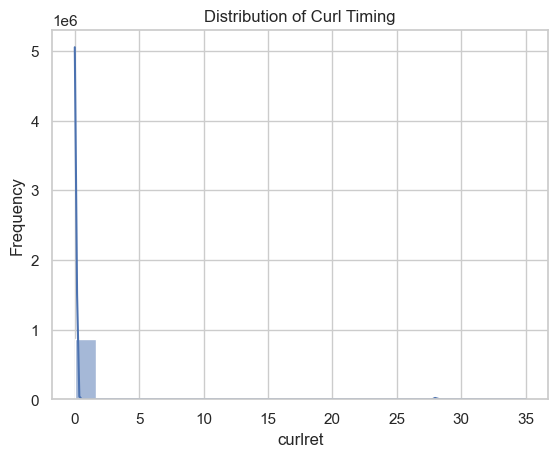

In [179]:
# Define columns to plot and their corresponding titles
timing_columns = {
    'timing_connect': 'Distribution of Connect Time',
    'timing_dns': 'Distribution of DNS Resolution Time',
    'timing_firstbyte': 'Distribution of Time to First Byte',
    'timing_receive': 'Distribution of Response Receive Time',
    'timing_send': 'Distribution of Send Time',
    'timing_ssl': 'Distribution of SSL Handshake Time',
    'timing_total': 'Distribution of Total Request Time',
    'timing_wait': 'Distribution of Wait Time (TTFB)',
    'tput': 'Distribution of Throughput',
    'curlret': 'Distribution of Curl Timing',
}

# Loop through the columns and plot
for col, title in timing_columns.items():
    if col in http_df.columns:
        sns.histplot(http_df[col], kde=True)
    elif col in ping_df.columns:
        sns.histplot(ping_df[col], kde=True)
    else:
        print(f"Column '{col}' not found in either dataframe.")
        continue
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

### Analysis of Performance Metrics Distributions

The provided charts visualize the distributions of various performance metrics, primarily focusing on network timing, throughput, and curl timing.

1. Timing Distributions (Connect, DNS, First Byte, Response Receive, SSL Handshake, Total Request, Wait)

For almost all timing-related metrics (Connect Time, DNS Resolution Time, Time to First Byte, Response Receive Time, SSL Handshake Time, Total Request Time, and Wait Time), the distributions are heavily right-skewed. A very large majority of requests complete with extremely fast times. For instance, most connections, DNS resolutions, and SSL handshakes occur within the first few hundred milliseconds (e.g., under 500ms). This indicates highly efficient general operation.
Long Tails: Despite the high concentration at low values, there are noticeable "long tails" extending to higher values (e.g., up to 3000-5000ms). This suggests that a small percentage of requests experience significantly longer delays, which could be due to network latency, server load, or specific request complexities.
Send Time Anomaly: The "Distribution of Send Time" is exceptionally concentrated at very low values (mostly under 5ms), with a very short tail. This indicates that the time taken to send data is consistently minimal for almost all requests.

2. Throughput Distribution

The "Distribution of Throughput" shows a different pattern compared to timing metrics. While also right-skewed, the values on the x-axis are much larger (up to 3.5e7).
Most throughput values are concentrated at the lower end, indicating that a large number of operations involve lower data transfer rates. However, there's a spread suggesting that some operations achieve significantly higher throughput.

Summary

In summary, the system generally demonstrates excellent performance with most operations completing very quickly and successfully. The presence of long tails in timing distributions warrants further investigation into the small percentage of requests that experience significant delays to understand potential bottlenecks or specific scenarios. The high success rate of curl operations is a positive indicator of system reliability.

### Plotting Configuration for categorical columns

We originally had plotted multiple categorical columns some of which were cardinal. That's why we defined the function, however it only made sense to plot the response code. 

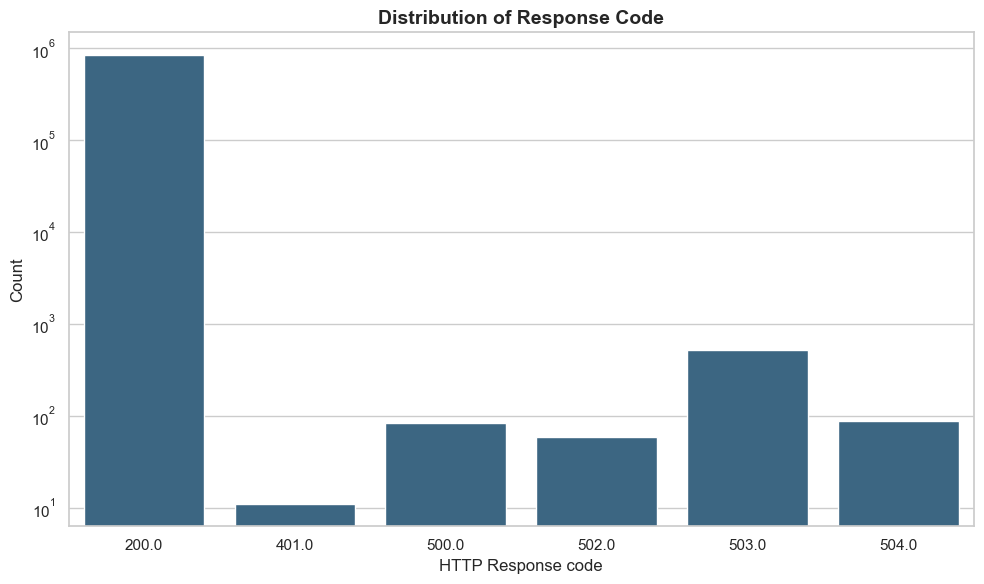

In [182]:
plot_configs = [
    {'col': 'responsecode', 'title': 'Distribution of Response Code', 'xlabel': 'HTTP Response code', 'log_scale': False},
]

# Global Plotting Settings
sns.set_style("whitegrid")
# Using a specific palette for consistency
palette = sns.color_palette("viridis", n_colors=len(plot_configs) + 1) # +1 for curl codes if needed

def plot_categorical_distribution(df, col_name, title, xlabel, color=None):
    """
    Plots the distribution of a categorical column using seaborn.countplot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        col_name (str): The name of the categorical column to plot.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        color (str): Color for the bars. If None, seaborn default is used.
    """
    if col_name not in df.columns:
        print(f"Warning: Column '{col_name}' not found in DataFrame. Skipping plot.")
        return

    plt.figure(figsize=(10, 6))
    ax=sns.countplot(data=df, x=col_name, color=color)

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    ax.set_yscale('log')
    plt.tight_layout()
    plt.show()

# Generate all plots using the enhanced functions ---
for i, config in enumerate(plot_configs):
    plot_categorical_distribution(
        http_df,
        col_name=config['col'],
        title=config['title'],
        xlabel=config['xlabel'],
        color=palette[i] # Use a distinct color from the palette
    )


### Key Observations from the Response code:

* 200 - success
* 401 - Unauthorized
* 500 - Internal Server Error
* 502 - Bad Gateway
* 503 - Service Unavailable
* 504 - Gateway timeout

From the data, it shows majority of success and service unavailable. We also have a lot of bad gateway, internal server errors and gateway timeout. It seems majority of true outages would be either 500, 502, 503 and 504 response codes.


### Agent specfic analysis HTTP Analysis

This section visualizes HTTP timing metrics collected from various agents (vAgentId) to identify discrepancies in performance characteristics. Each boxplot illustrates the distribution of a particular timing metric, such as DNS resolution, connection time, or time to first byte (TTFB), across different agents.

**NOTE: After checking with my colleague, we found out that different agents are in different geographical location so it does not make sense to do agent to agent or test to test comparison. However, for this project, I kept the analysis to show understanding with the data.**

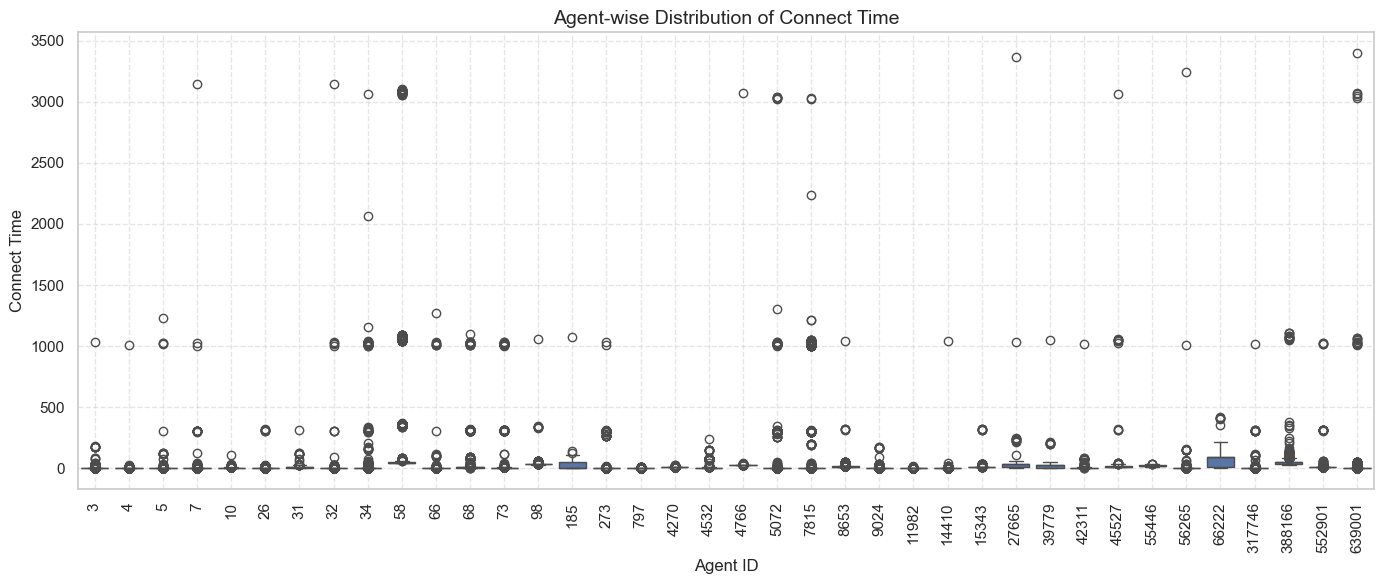

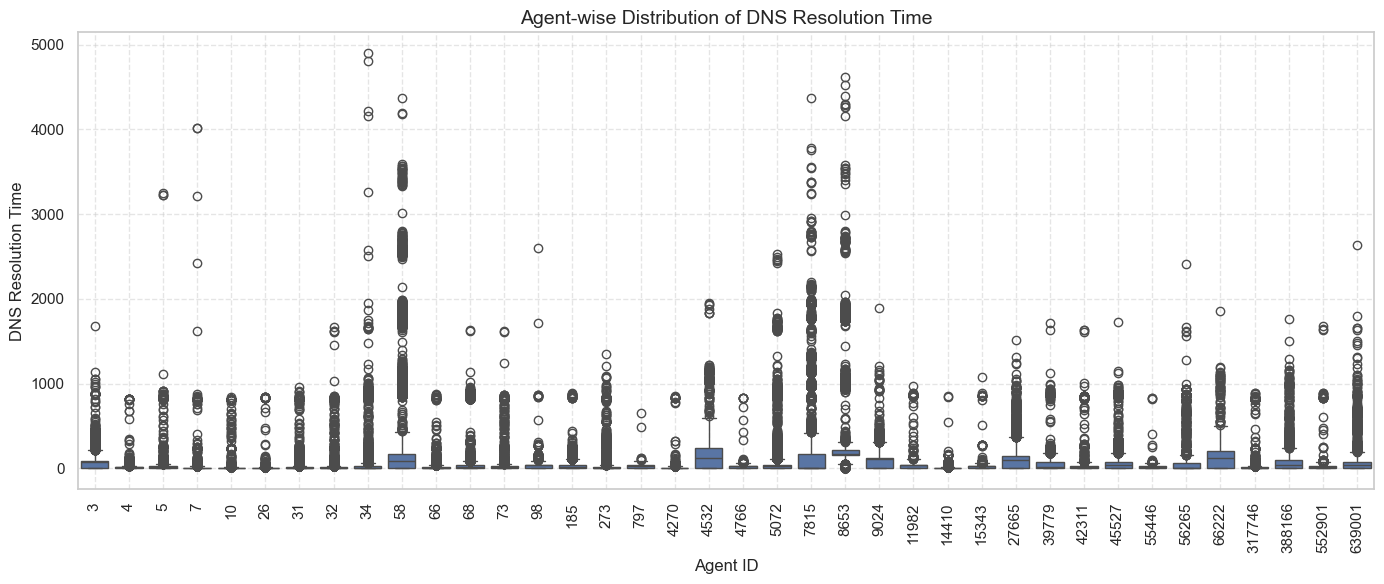

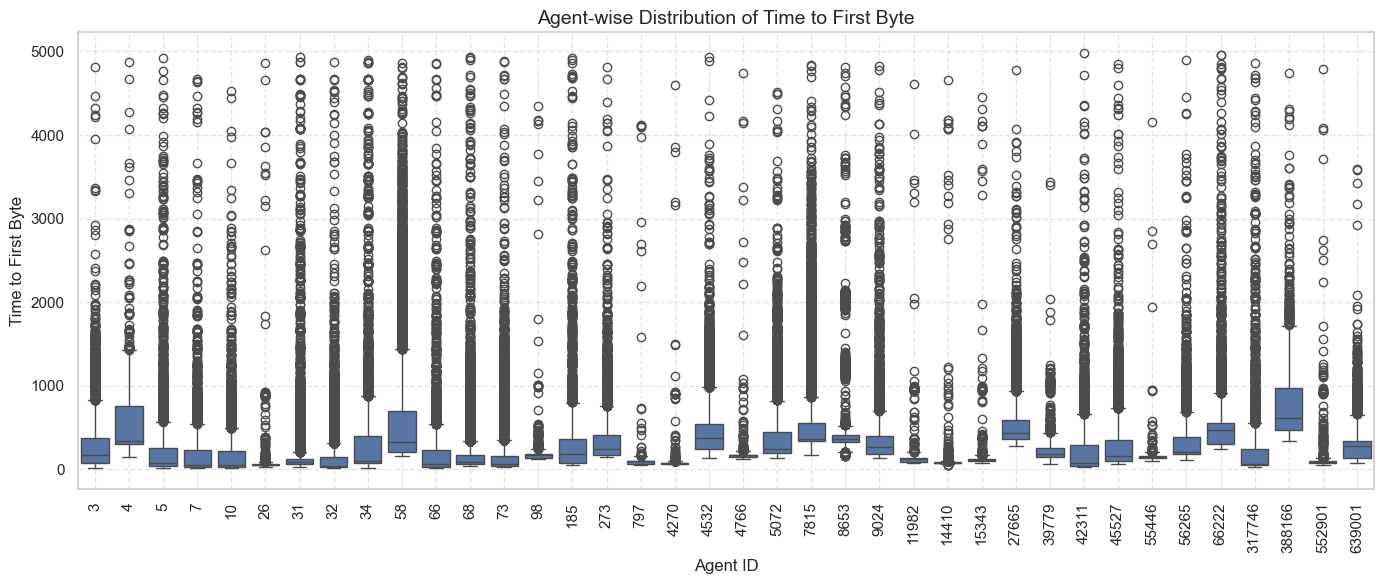

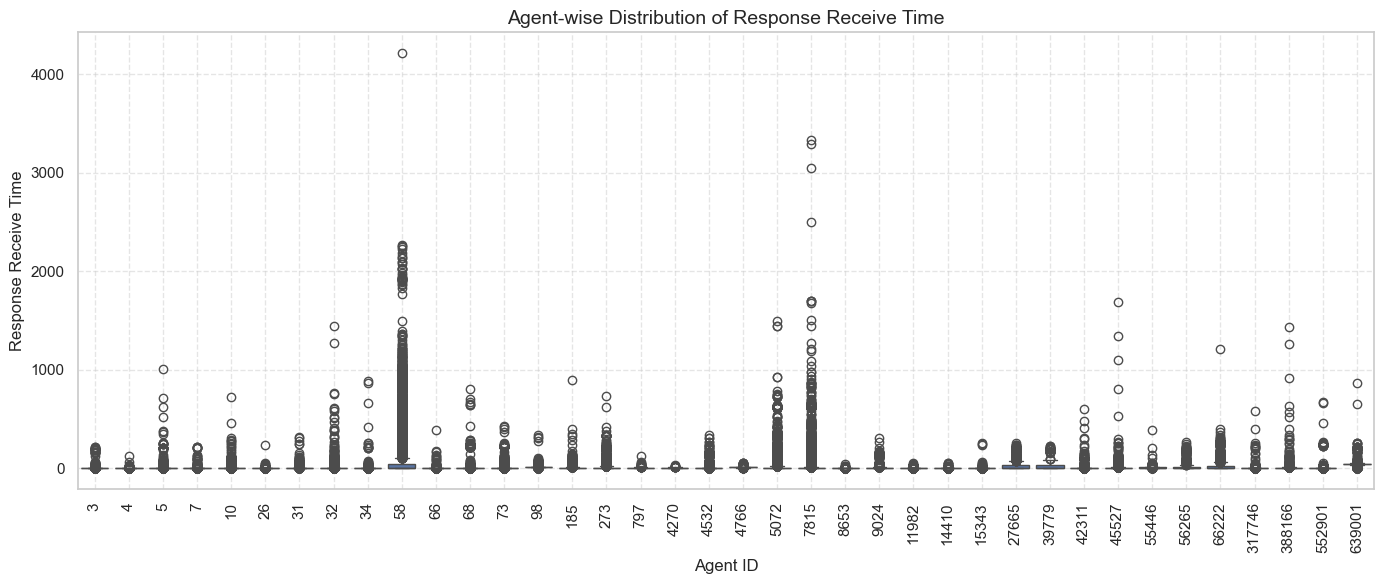

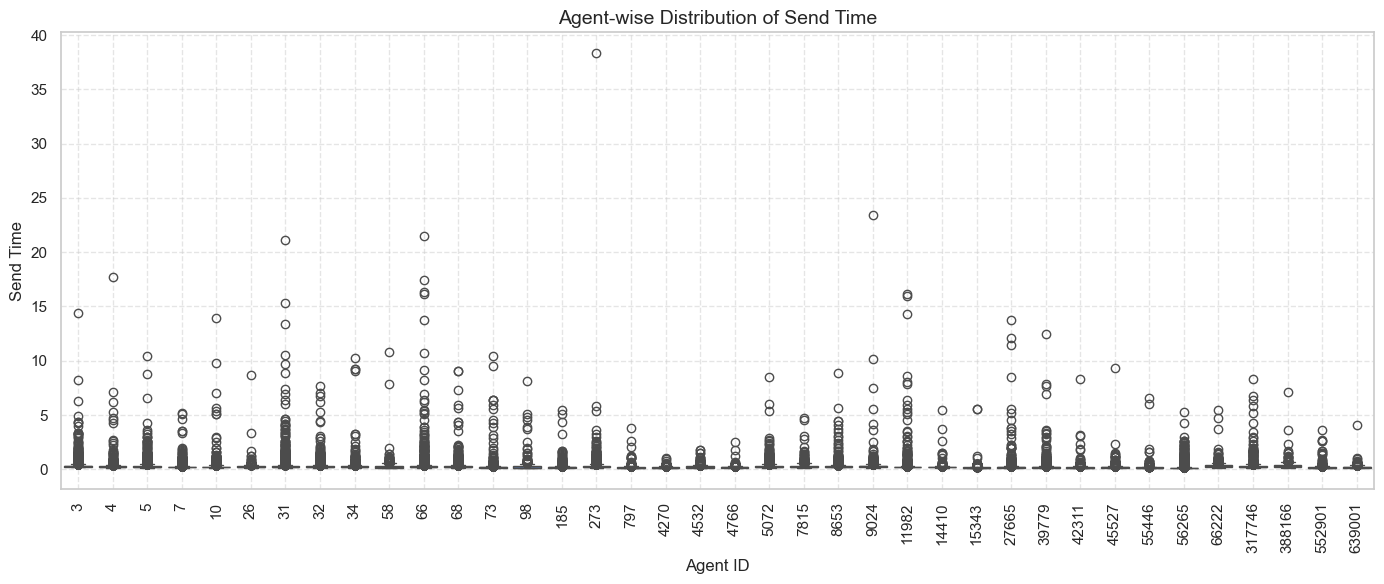

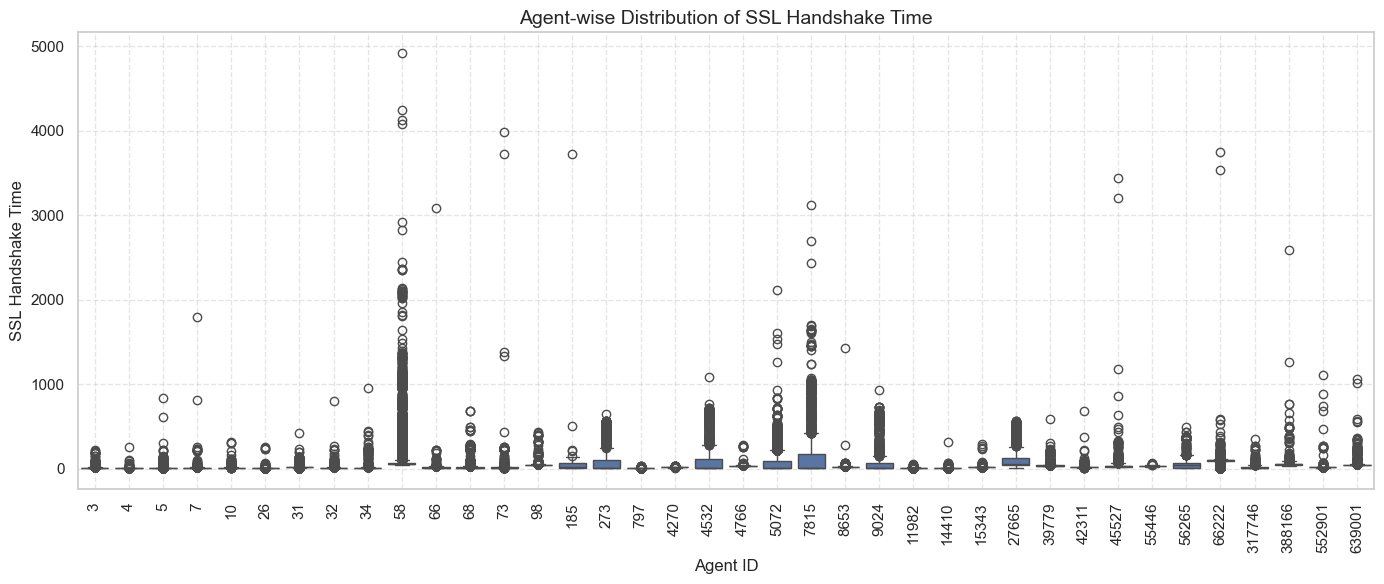

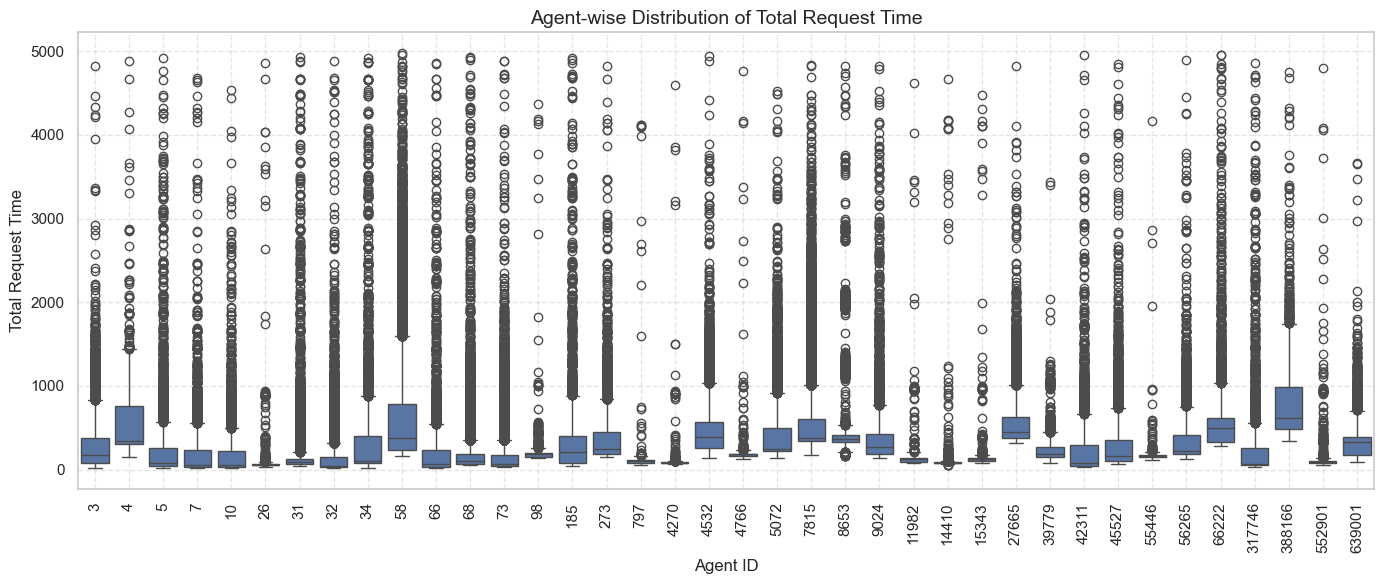

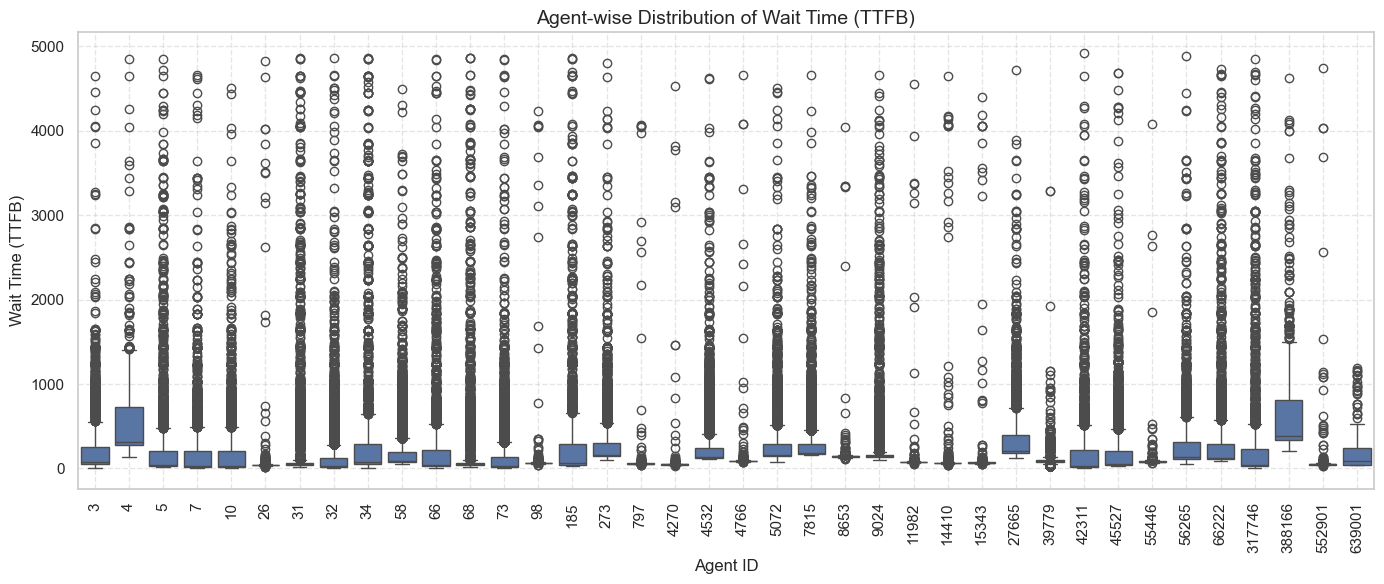

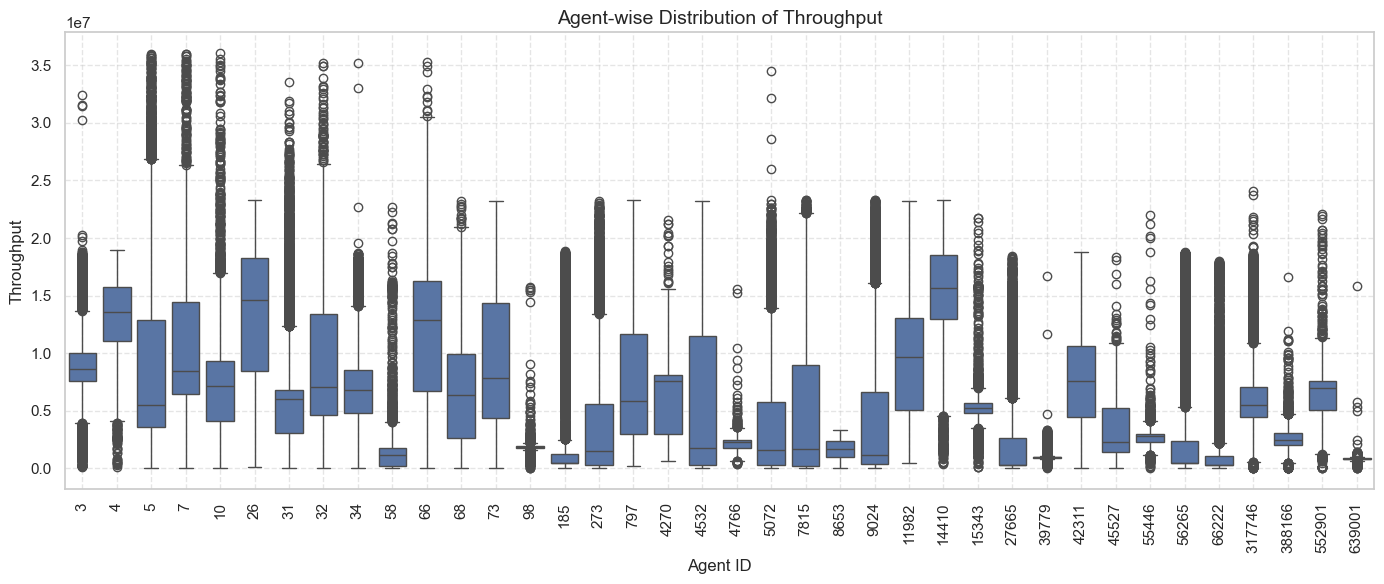

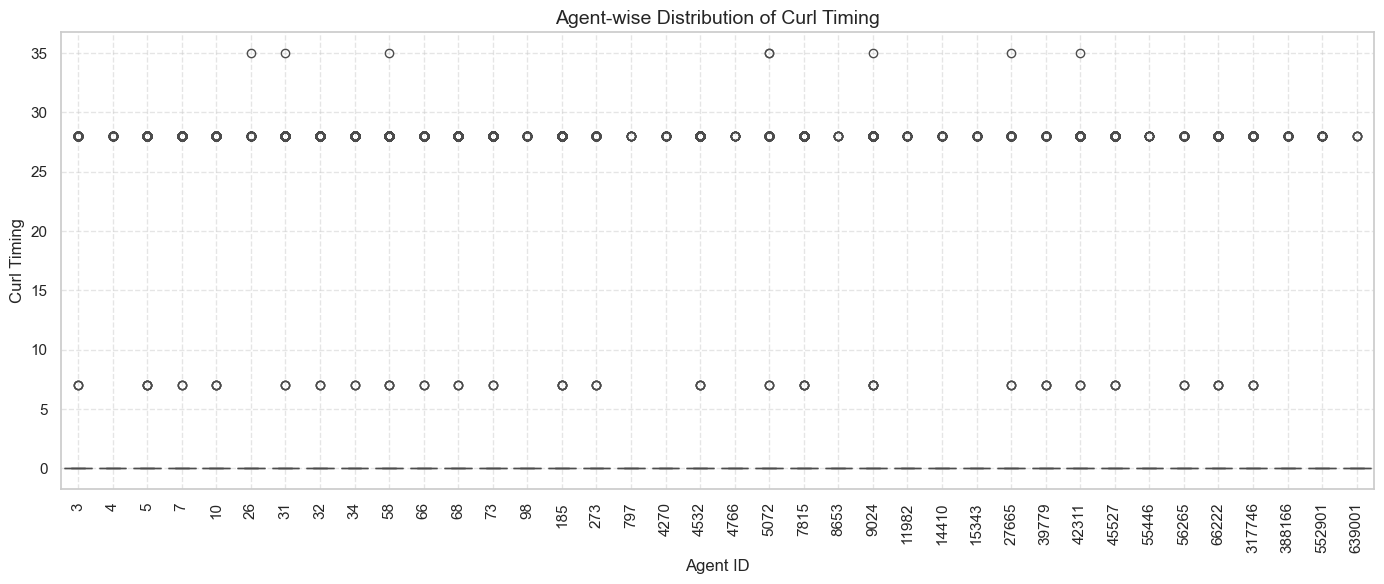

In [185]:
# Apply a cleaner theme
sns.set(style="whitegrid")

# Define timing-related columns and their descriptive titles
timing_columns = {
    'timing_connect': 'Connect Time',
    'timing_dns': 'DNS Resolution Time',
    'timing_firstbyte': 'Time to First Byte',
    'timing_receive': 'Response Receive Time',
    'timing_send': 'Send Time',
    'timing_ssl': 'SSL Handshake Time',
    'timing_total': 'Total Request Time',
    'timing_wait': 'Wait Time (TTFB)',
    'tput': 'Throughput',
    'curlret': 'Curl Timing',
}

# Determine unique agents in order for consistent x-axis
agent_order = sorted(http_df['vAgentId'].unique())

# Plotting
for col, label in timing_columns.items():
    data = None
    if col in http_df.columns:
        data = http_df
    elif col in ping_df.columns:
        data = ping_df
    else:
        print(f"Column '{col}' not found in either dataframe.")
        continue

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=data, x='vAgentId', y=col, order=agent_order)
    plt.title(f"Agent-wise Distribution of {label}", fontsize=14)
    plt.xlabel("Agent ID")
    plt.ylabel(label)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


Significant variation in metrics like `Total Request Time` or `SSL Handshake Time` is indicating network or configuration issues on specific agents. However, we are not performing agent to agent comparison as indicated above.


### Test-Specific HTTP Timing Analysis
This section investigates how HTTP performance metrics vary across different test IDs, helping identify performance inconsistencies tied to specific tests or monitored URLs. However, this analysis is kept for the project purpose as test are configured across multiple regions asynchronously as confirmed by my colleague. 


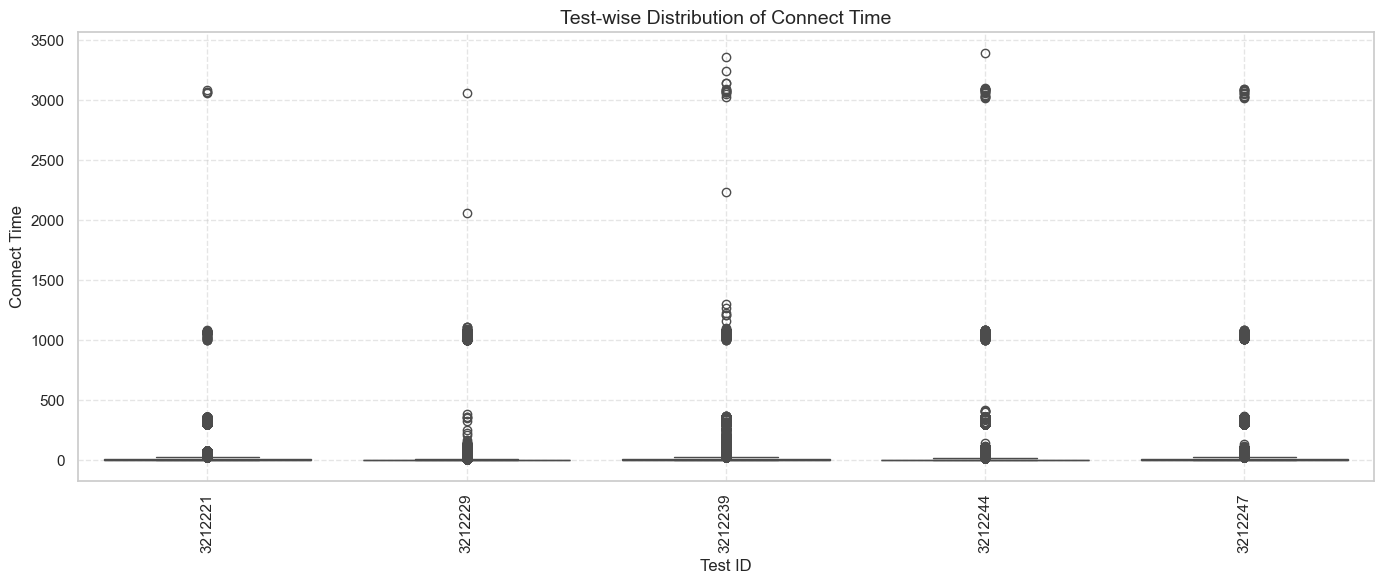

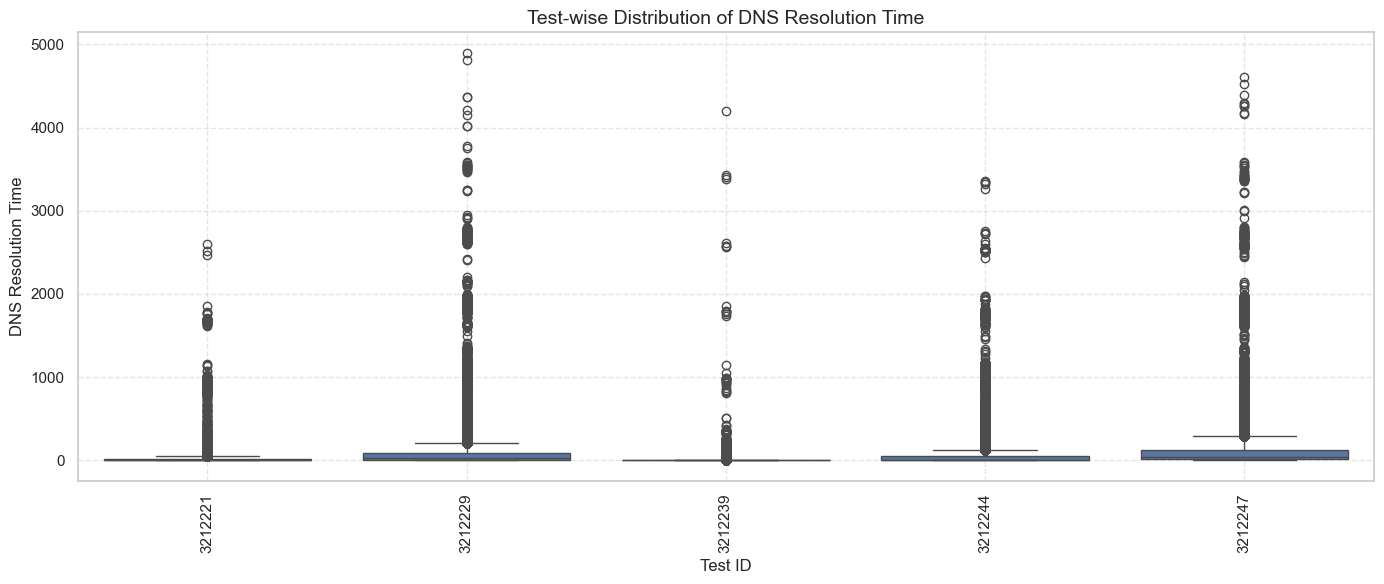

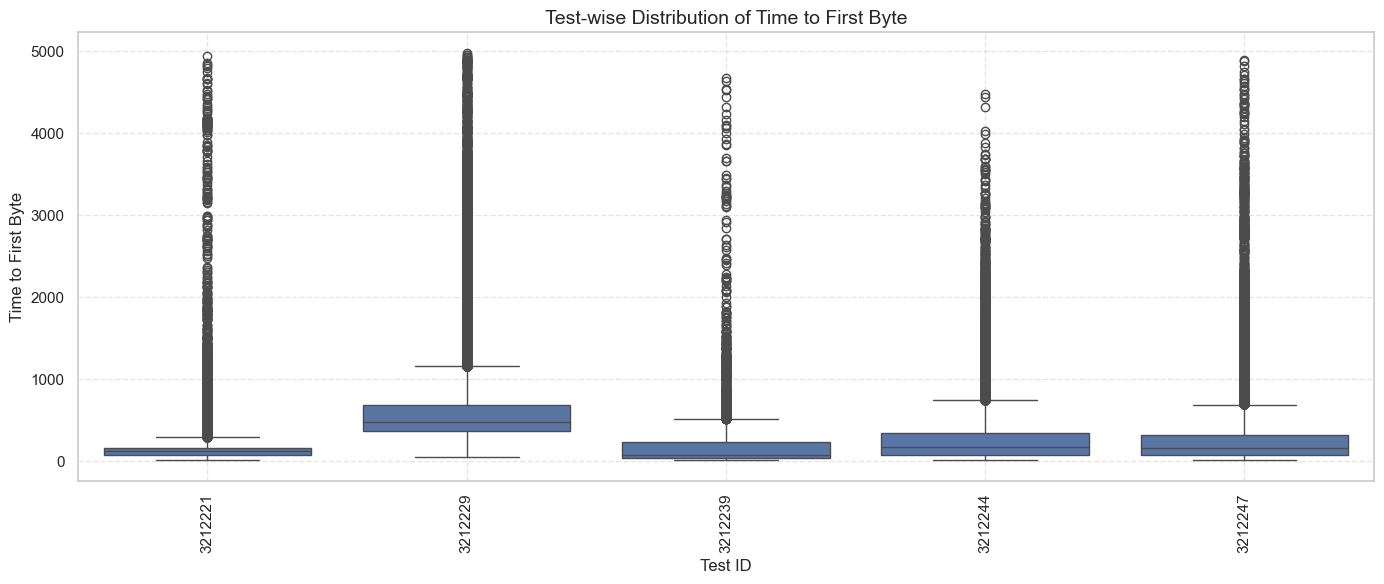

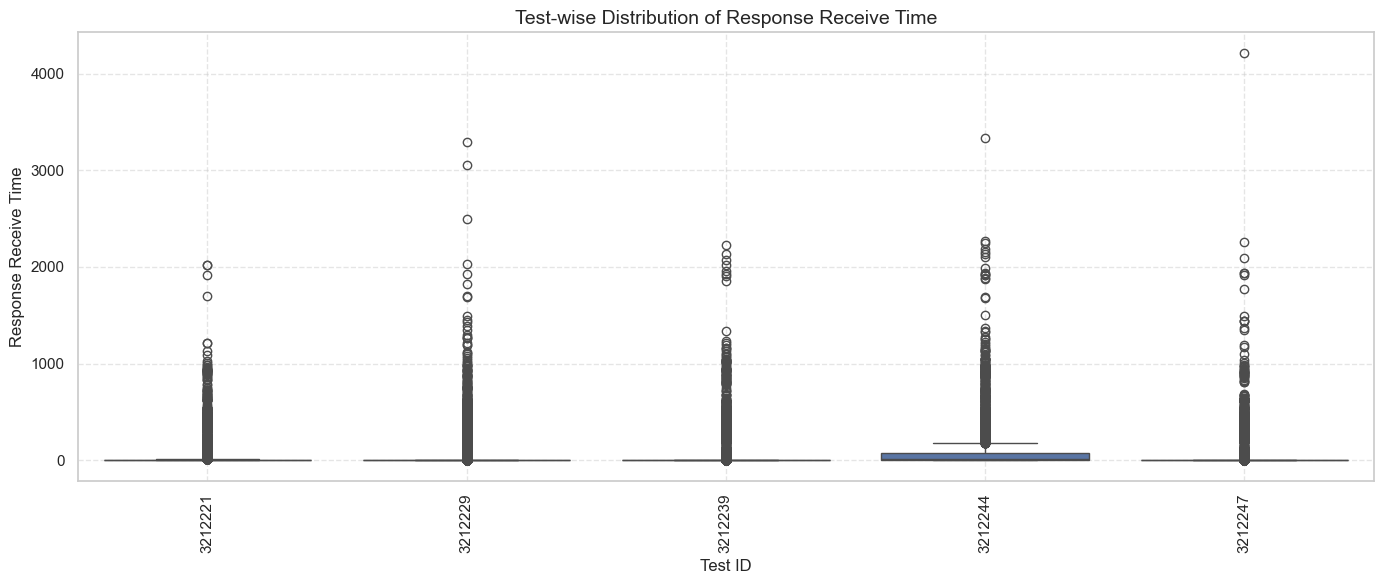

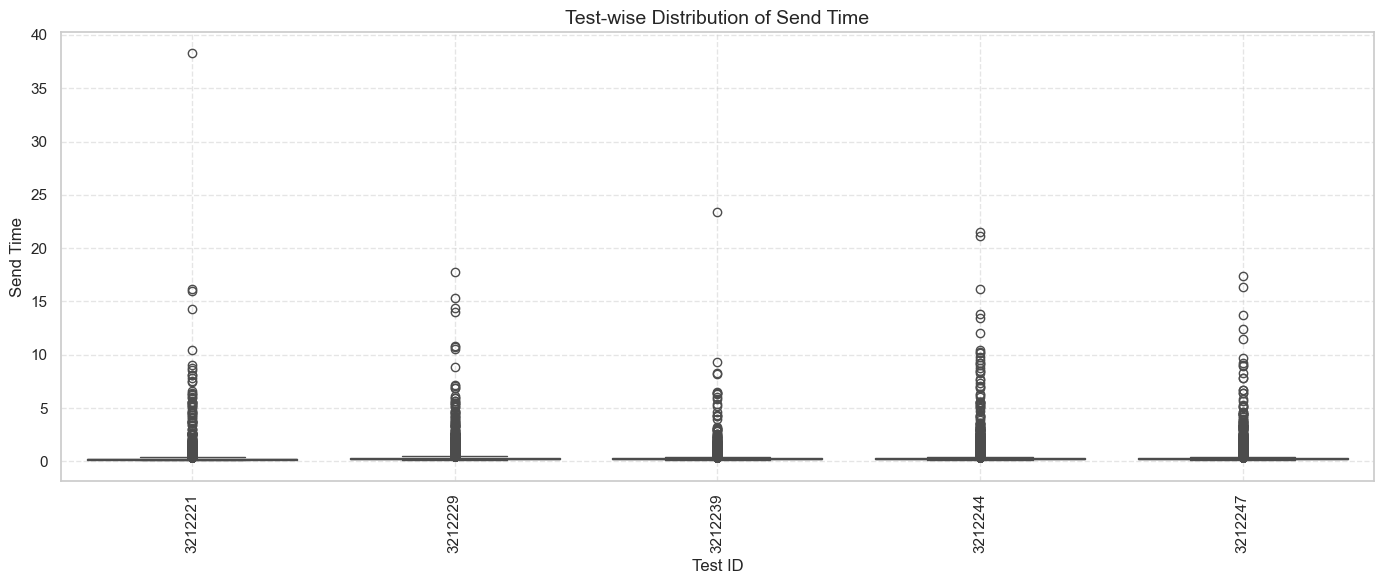

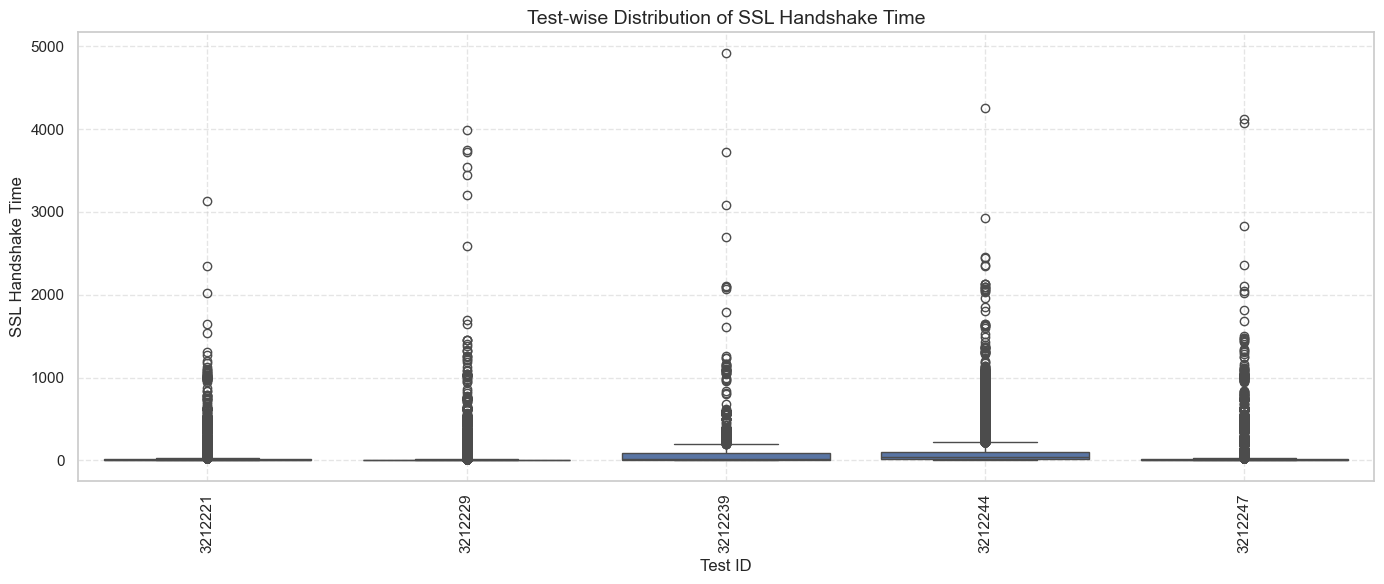

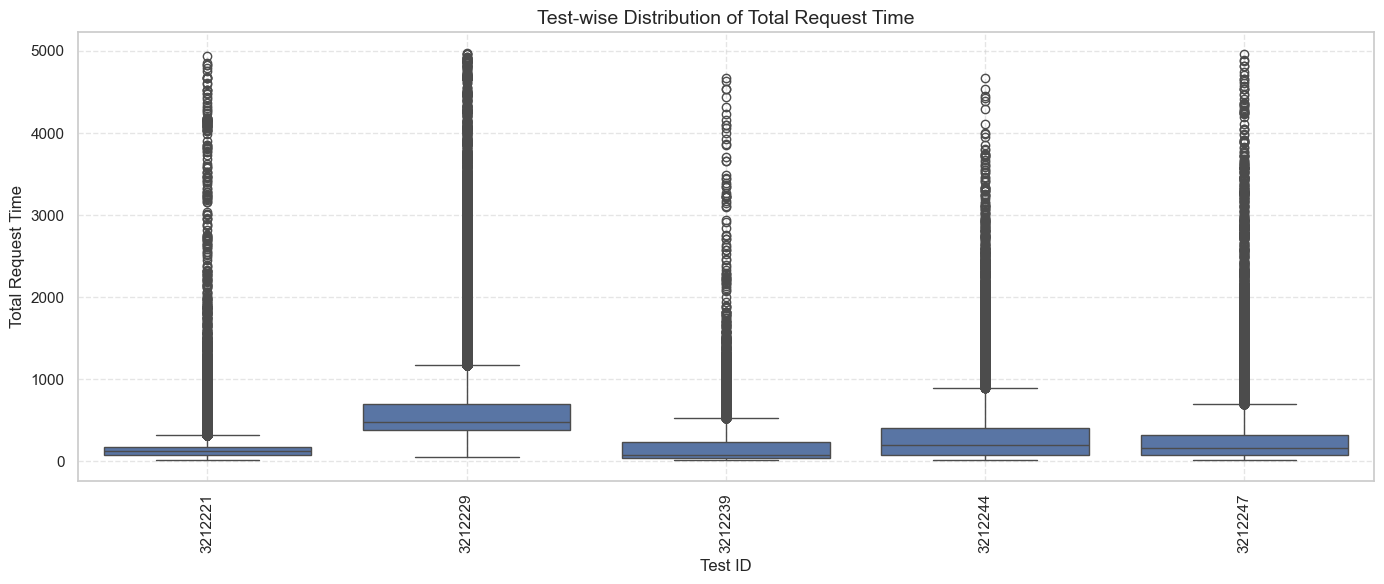

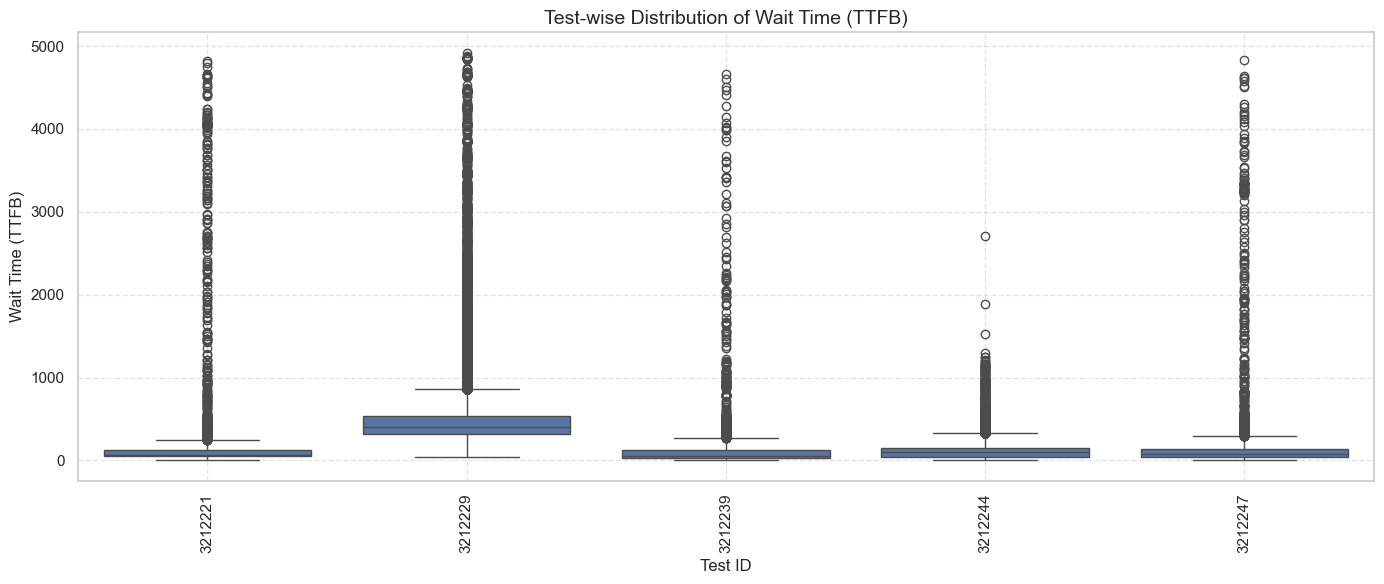

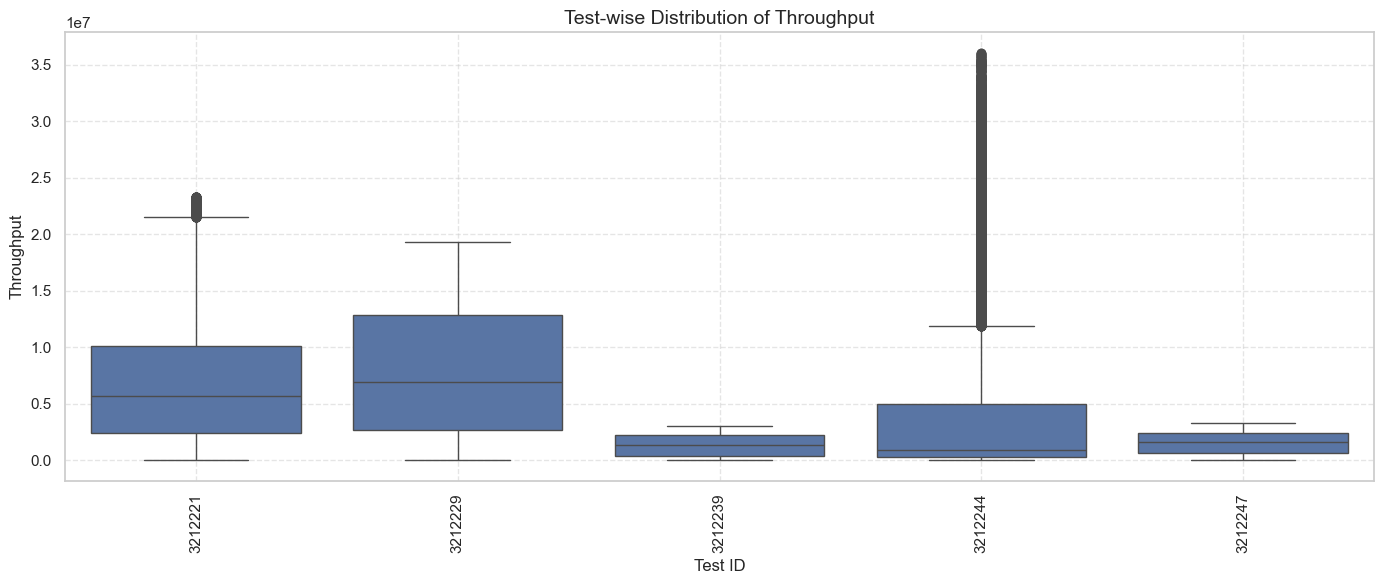

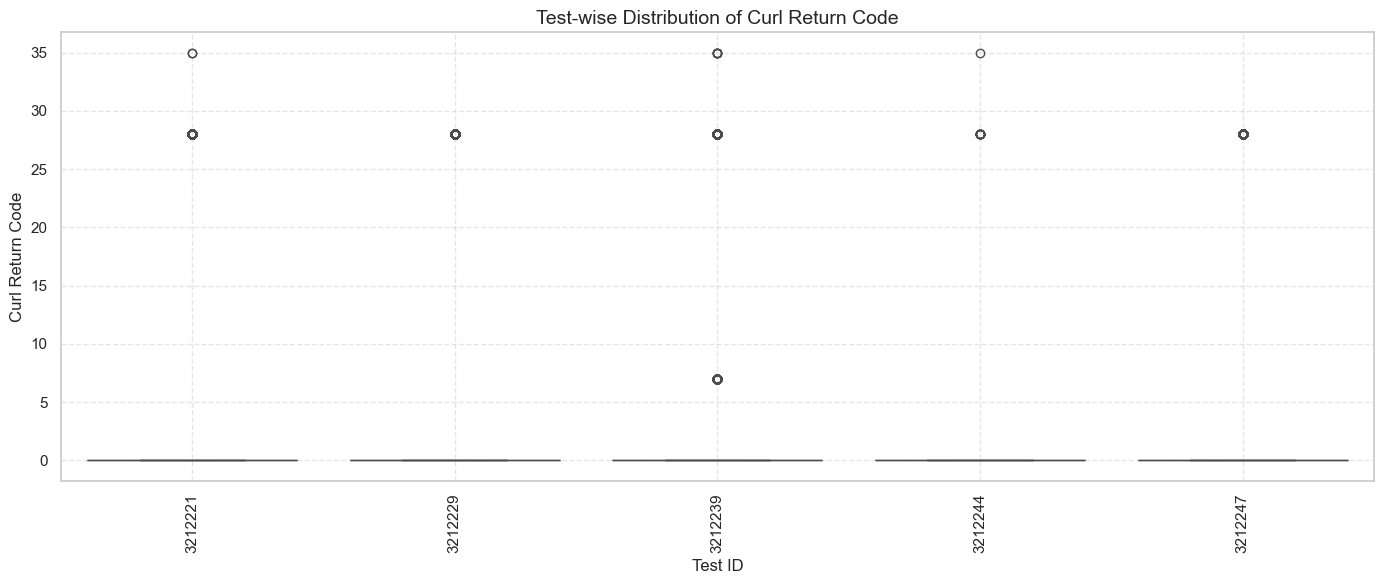

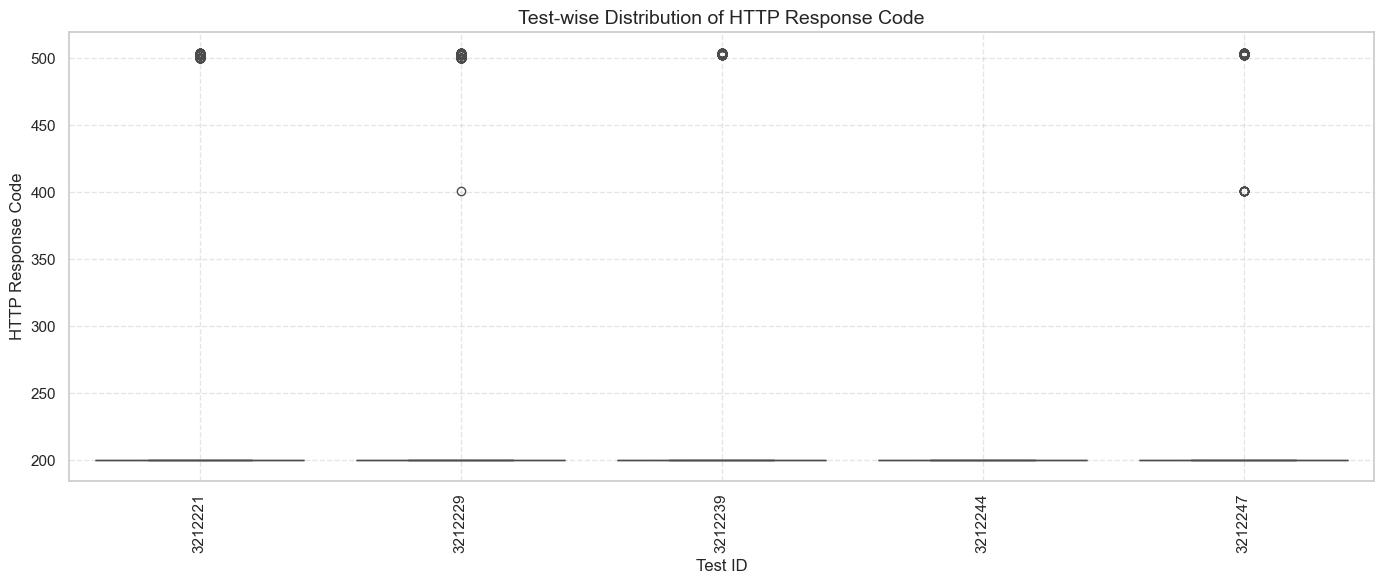

In [188]:

# Set global plot style
sns.set(style="whitegrid")

# Define timing-related columns and their descriptive titles
timing_columns = {
    'timing_connect': 'Connect Time',
    'timing_dns': 'DNS Resolution Time',
    'timing_firstbyte': 'Time to First Byte',
    'timing_receive': 'Response Receive Time',
    'timing_send': 'Send Time',
    'timing_ssl': 'SSL Handshake Time',
    'timing_total': 'Total Request Time',
    'timing_wait': 'Wait Time (TTFB)',
    'tput': 'Throughput',
    'curlret': 'Curl Return Code',
    'responsecode': 'HTTP Response Code'
}

# Get sorted unique test IDs for consistent x-axis
test_order = sorted(http_df['testId'].unique())

# Loop through each timing column and plot per testId
for col, label in timing_columns.items():
    if col in http_df.columns:
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=http_df, x='testId', y=col, order=test_order)
        plt.title(f"Test-wise Distribution of {label}", fontsize=14)
        plt.xlabel("Test ID")
        plt.ylabel(label)
        plt.xticks(rotation=90)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' not found in http_df.")


- Certain tests consistently show higher `Total Request Time`, suggesting backend slowness, large payloads, or third-party dependencies.
- `Time to First Byte (TTFB)` and `Connect Time` vary widely among tests, indicating potential differences in server responsiveness or network routing.
- A few tests demonstrate high `SSL Handshake Time`, which could point to certificate issues or TLS overhead on target services. 

### Correlation of Total Request Time with Other HTTP Metrics

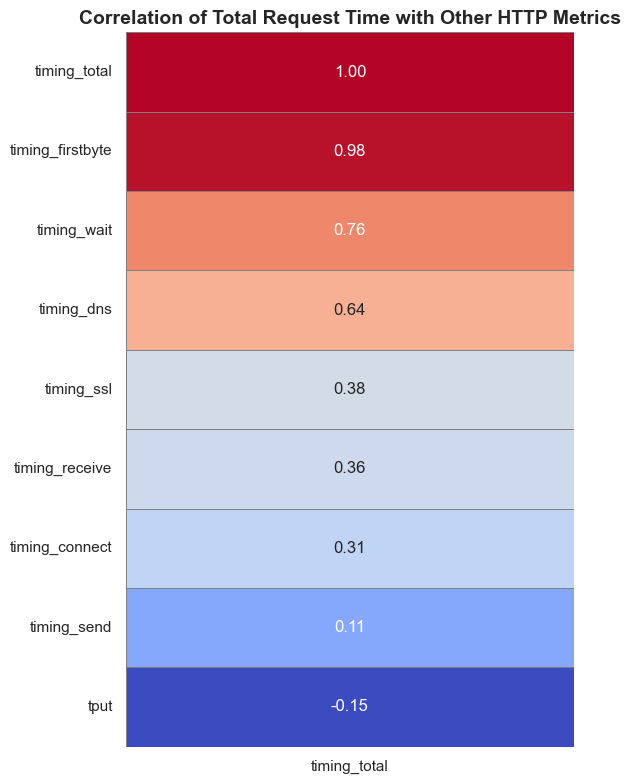

In [191]:
# lets analyze the correlation between total response time with other HTTP metrics
# Define the relevant columns
timing_columns = [
    'timing_connect',     # Connect Time
    'timing_dns',         # DNS Resolution Time
    'timing_firstbyte',   # Time to First Byte
    'timing_receive',     # Response Receive Time
    'timing_send',        # Send Time
    'timing_ssl',         # SSL Handshake Time
    'timing_total',       # Total Request Time (Target)
    'timing_wait',        # Wait Time (TTFB)
    'tput',               # Throughput
]

# Subset the HTTP data to include only relevant numeric columns and drop NaNs
correlation_data = http_df[timing_columns].dropna()

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Extract only the correlations with 'timing_total', sort by strength
correlation_with_total = correlation_matrix[['timing_total']].sort_values(by='timing_total', ascending=False)

# Plot the correlation heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(correlation_with_total, annot=True, cmap='coolwarm', fmt=".2f", cbar=False,
            linewidths=0.5, linecolor='gray')
plt.title("Correlation of Total Request Time with Other HTTP Metrics", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


### Correlation Analysis: Total Request Time vs. HTTP Timing Components

timing_firstbyte a very strong positive correlation (0.98) with timing_total, suggesting that the time to receive the first byte is a major component or indicator of the total request time. 
timing_wait (0.76) and timing_dns (0.64) also show strong positive correlations, indicating they significantly contribute to or are highly related to the total request time.
timing_ssl, timing_receive, and timing_connect have moderate positive correlations.
timing_send has a very weak positive correlation (0.11).
tput (throughput) shows a weak negative correlation (-0.15), which might imply that higher throughput is associated with slightly lower total request times, though the correlation is not strong.

## Baseline Modeling 
Using linear regression model for a simple exploration.

In [194]:
# We aim to build a simple linear regression model to predict total HTTP request time using individual timing metrics like DNS resolution, connection, and wait time. The model achieved an R² score of X.XX, indicating it can explain approximately XX% of the variation in total request time. 
# The correlation heatmap showed strong relationships between timing_wait, timing_receive, and the timing total (target). 
# Coefficient analysis confirmed these features had the largest impact on request duration.

# Define features and target
features = [
    'timing_dns',
    'timing_connect',
    'timing_ssl',
    'timing_send',
    'timing_wait',
    'timing_receive',
   #'timing_firstbyte'- as confirmed by my colleague is a cumulative metric.
]

target = 'timing_total'

In [195]:
# Drop missing values from our features we are trying to measure and target i.e. timing_total
data = http_df[features + [target]].dropna()

X = data[features]
y = data[target]

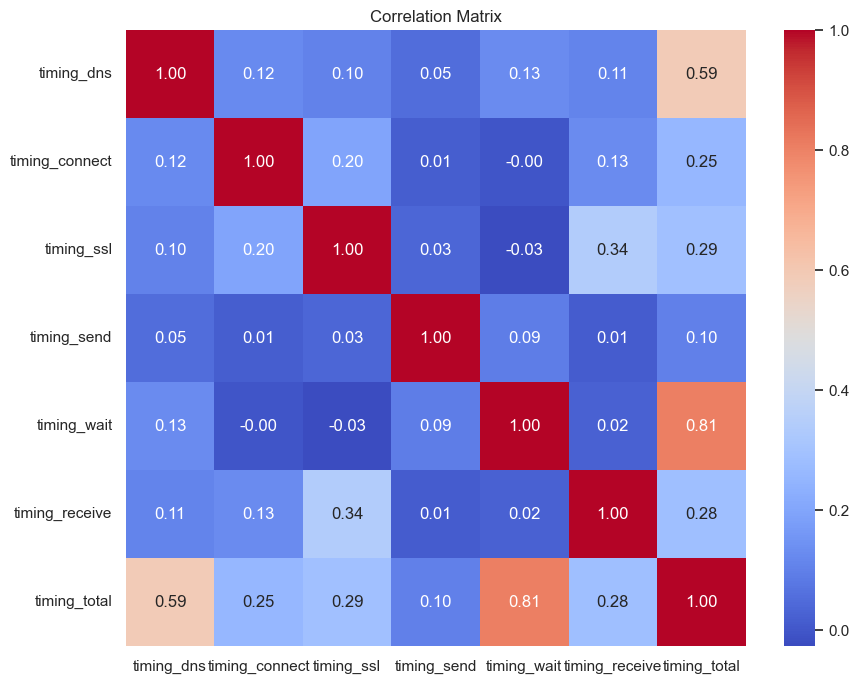

In [196]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [197]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [198]:
# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 0.00
R^2 Score: 1.00


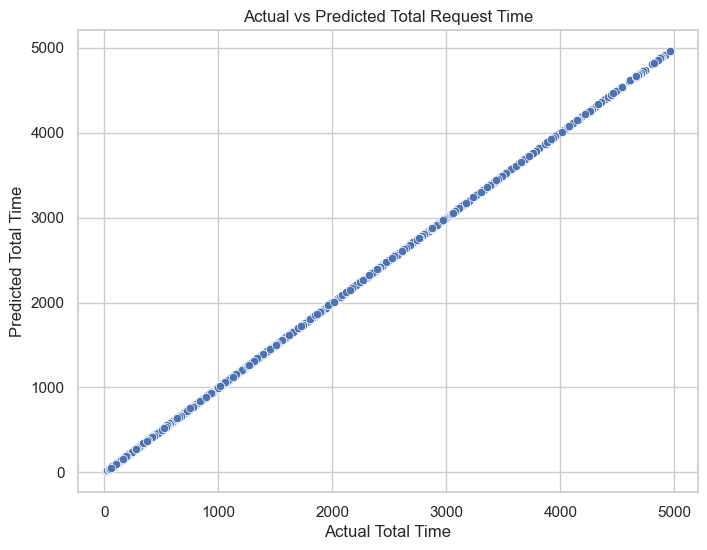

In [199]:
# Plot actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Total Time")
plt.ylabel("Predicted Total Time")
plt.title("Actual vs Predicted Total Request Time")
plt.grid(True)
plt.show()

In [200]:
# Model interpretation: Coefficients
coeffs = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("Feature Importance (based on linear regression coefficients):")
print(coeffs)

Feature Importance (based on linear regression coefficients):
          Feature  Coefficient
3     timing_send     1.013378
5  timing_receive     1.000030
0      timing_dns     1.000026
4     timing_wait     1.000014
1  timing_connect     0.999991
2      timing_ssl     0.999985


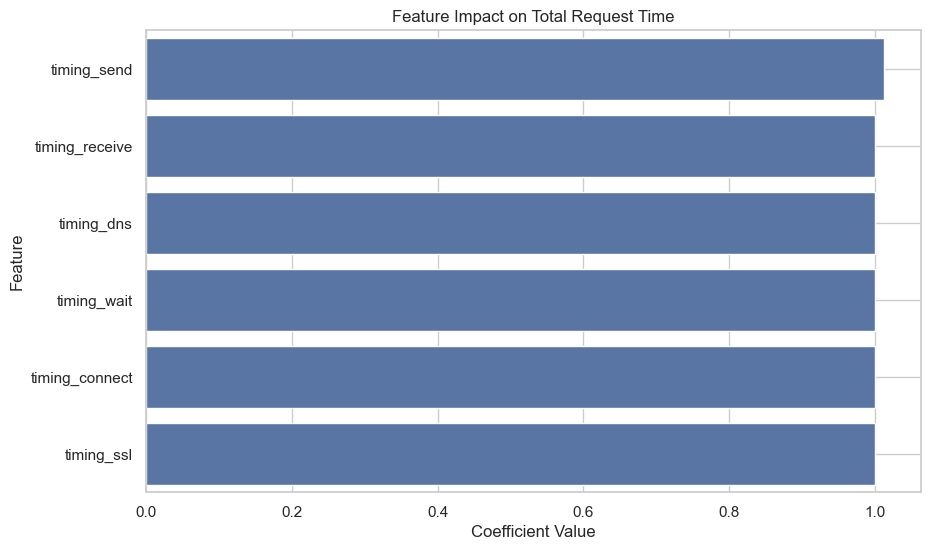

In [201]:
# Barplot of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeffs)
plt.title("Feature Impact on Total Request Time")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

It seems like there are very predictable weightings for each of the individual parameters because our linear regression model shows 100% accuracy which shows we are not modeling the right inputs and outputs maybe it is better to predict future total time based of the time series data from the individual agent ID data. As a next step, I will check with my colleague if the time stamp in the dataset is available. 